# How well can you predict letting rates on AirBNB?

## With this data, your goal is to minimize error in predicting the nightly price of an AirBnB

In order to approach this question, a series of models will be explored in an attempt to minimize the mean squared error (MSE), whilst reducing the presence of overfitting

In order to begin, a series of packages are installed to allow for data analytics and machine learning to take place

## Loading relevant packages

In [1]:
from sklearn.neighbors import KNeighborsRegressor
from sklearn.metrics import mean_squared_error, r2_score, accuracy_score, log_loss
from sklearn.model_selection import GridSearchCV, train_test_split, cross_validate, KFold, ShuffleSplit
from sklearn.preprocessing import StandardScaler, MinMaxScaler
import pandas as pd
import seaborn as sns
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor as GBR
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.pyplot import subplots
import statsmodels.api as sm
from statsmodels.stats.outliers_influence import variance_inflation_factor as VIF
from statsmodels.stats.anova import anova_lm
from statsmodels.datasets import get_rdataset 
from ISLP import load_data, confusion_table
from ISLP.models import ModelSpec as MS, summarize, poly, sklearn_sm
from sklearn.tree import DecisionTreeClassifier as DTC, DecisionTreeRegressor as DTR, plot_tree, export_text
from ISLP.bart import BART
import math
import time
import xgboost as xgb
import datetime
from tensorflow import keras
from tensorflow.keras.utils import model_to_dot
from tensorflow.keras import models, layers, optimizers, regularizers
from tensorflow.keras.callbacks import EarlyStopping
from IPython.display import SVG
import pydot
import random
import tensorflow as tf

2024-05-20 20:38:37.784049: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


## Reading in the data

In [2]:
AirBnB = pd.read_csv("airbnbs.csv") #Reading in the data
AirBnB.columns #Exploring the variables present

Index(['id', 'listing_url', 'scrape_id', 'last_scraped', 'source', 'name',
       'description', 'neighborhood_overview', 'picture_url', 'host_id',
       'host_url', 'host_name', 'host_since', 'host_location', 'host_about',
       'host_response_time', 'host_response_rate', 'host_acceptance_rate',
       'host_is_superhost', 'host_thumbnail_url', 'host_picture_url',
       'host_neighbourhood', 'host_listings_count',
       'host_total_listings_count', 'host_verifications',
       'host_has_profile_pic', 'host_identity_verified', 'neighbourhood',
       'neighbourhood_cleansed', 'neighbourhood_group_cleansed', 'latitude',
       'longitude', 'property_type', 'room_type', 'accommodates', 'bathrooms',
       'bathrooms_text', 'bedrooms', 'beds', 'amenities', 'price',
       'minimum_nights', 'maximum_nights', 'minimum_minimum_nights',
       'maximum_minimum_nights', 'minimum_maximum_nights',
       'maximum_maximum_nights', 'minimum_nights_avg_ntm',
       'maximum_nights_avg_ntm', 'ca

Before pre-processing the data, it is important to see how many observations we are dealing with

In [3]:
AirBnB.shape

(2556, 75)

The full data is made up of 2556 AirBnBs, with 75 variables

## Feature selection and data processing

Firstly, it is worth noting which variable columns have all NaN values, as these are not useful for modelling as they provide no information

In [4]:
# Checking for NaN values in each column
nan_columns = AirBnB.columns[AirBnB.isnull().all()].tolist()

# Highlight columns with all NaN values
highlighted_columns = {col: 'highlight' for col in nan_columns}

# Display the result
print("Columns with NaN values for all entries:")
print(highlighted_columns)


Columns with NaN values for all entries:
{'description': 'highlight', 'neighbourhood_group_cleansed': 'highlight', 'bathrooms': 'highlight', 'bedrooms': 'highlight', 'calendar_updated': 'highlight', 'license': 'highlight'}


As these variables do not have any values, these have been removed and are not considered in this research

In [5]:
AirBnB = AirBnB.drop(['description', 
                      'neighbourhood_group_cleansed', 
                      'bathrooms', 
                      'bedrooms', 
                      'calendar_updated', 
                      'license'], 
                     axis=1)

At this stage, it is worth dropping features that have no place in a predictive model. These include URLs and ambiguous variables, and variables that are very similar to eachother.

In [6]:
AirBnB = AirBnB.drop(['id', #not relevant 
                      'listing_url', #free text
                      'scrape_id', #not relevant
                      'last_scraped', #not relevant
                      'source', #not relevant
                      'name', #not relevant
                     'picture_url', #not relevant
                     'host_id',#not relevant
                     'host_url',#not relevant
                     'host_name',#not relevant
                     'host_thumbnail_url',#not relevant
                     'host_picture_url',#not relevant
                     'host_neighbourhood', #ambiguous
                     'neighbourhood',#ambiguous
                     'neighbourhood_cleansed',#ambiguous
                     'calendar_last_scraped',#not relevant
                     'first_review', #closely linked to number of reviews which will be considered
                     'last_review', #closely linked to number of reviews which will be considered
                     'calculated_host_listings_count', #closely linked to the number of listings which is considered
                      'calculated_host_listings_count_entire_homes', #closely linked to the number of listings which is considered
                      'calculated_host_listings_count_private_rooms', #closely linked to the number of listings which is considered
                      'calculated_host_listings_count_shared_rooms', #closely linked to the number of listings which is considered
                     'host_verifications', #ambiguous
                     'host_listings_count', #the total_host_listings_count is used instead
                     'availability_30', #overall availability is considered instead 
                     'availability_60', #overall availability is considered instead 
                     'availability_90', #overall availability is considered instead 
                     'availability_365', #overall availability is considered instead 
                     'number_of_reviews_ltm', #total number of reviews is considered instead
                     'number_of_reviews_l30d', #total number of reviews is considered instead
                     'reviews_per_month',#total number of reviews is considered instead
                     'minimum_minimum_nights', #the min/max nights is used instead 
                     'maximum_minimum_nights', #the min/max nights is used instead 
                      'minimum_maximum_nights', #the min/max nights is used instead 
                      'maximum_maximum_nights', #the min/max nights is used instead 
                      'minimum_nights_avg_ntm', #the min/max nights is used instead 
                      'maximum_nights_avg_ntm'], #the min/max nights is used instead 
                     axis=1)

It is useful to look at the columns with NaN values.

In [7]:
AirBnB.isna().sum()

neighborhood_overview           906
host_since                        0
host_location                   455
host_about                     1045
host_response_time              451
host_response_rate              451
host_acceptance_rate            216
host_is_superhost                 2
host_total_listings_count         0
host_has_profile_pic              0
host_identity_verified            0
latitude                          0
longitude                         0
property_type                     0
room_type                         0
accommodates                      0
bathrooms_text                    1
beds                             55
amenities                         0
price                           387
minimum_nights                    0
maximum_nights                    0
has_availability                387
number_of_reviews                 0
review_scores_rating            381
review_scores_accuracy          382
review_scores_cleanliness       382
review_scores_checkin       

A lot of columns have several NaN values present. A lot of these variables can be adjusted to avoid removing large amounts from the dataset.

Before removing any NaN values, it is worth checking whether boolean and categorical features contain sufficient data to make them worthwhile including

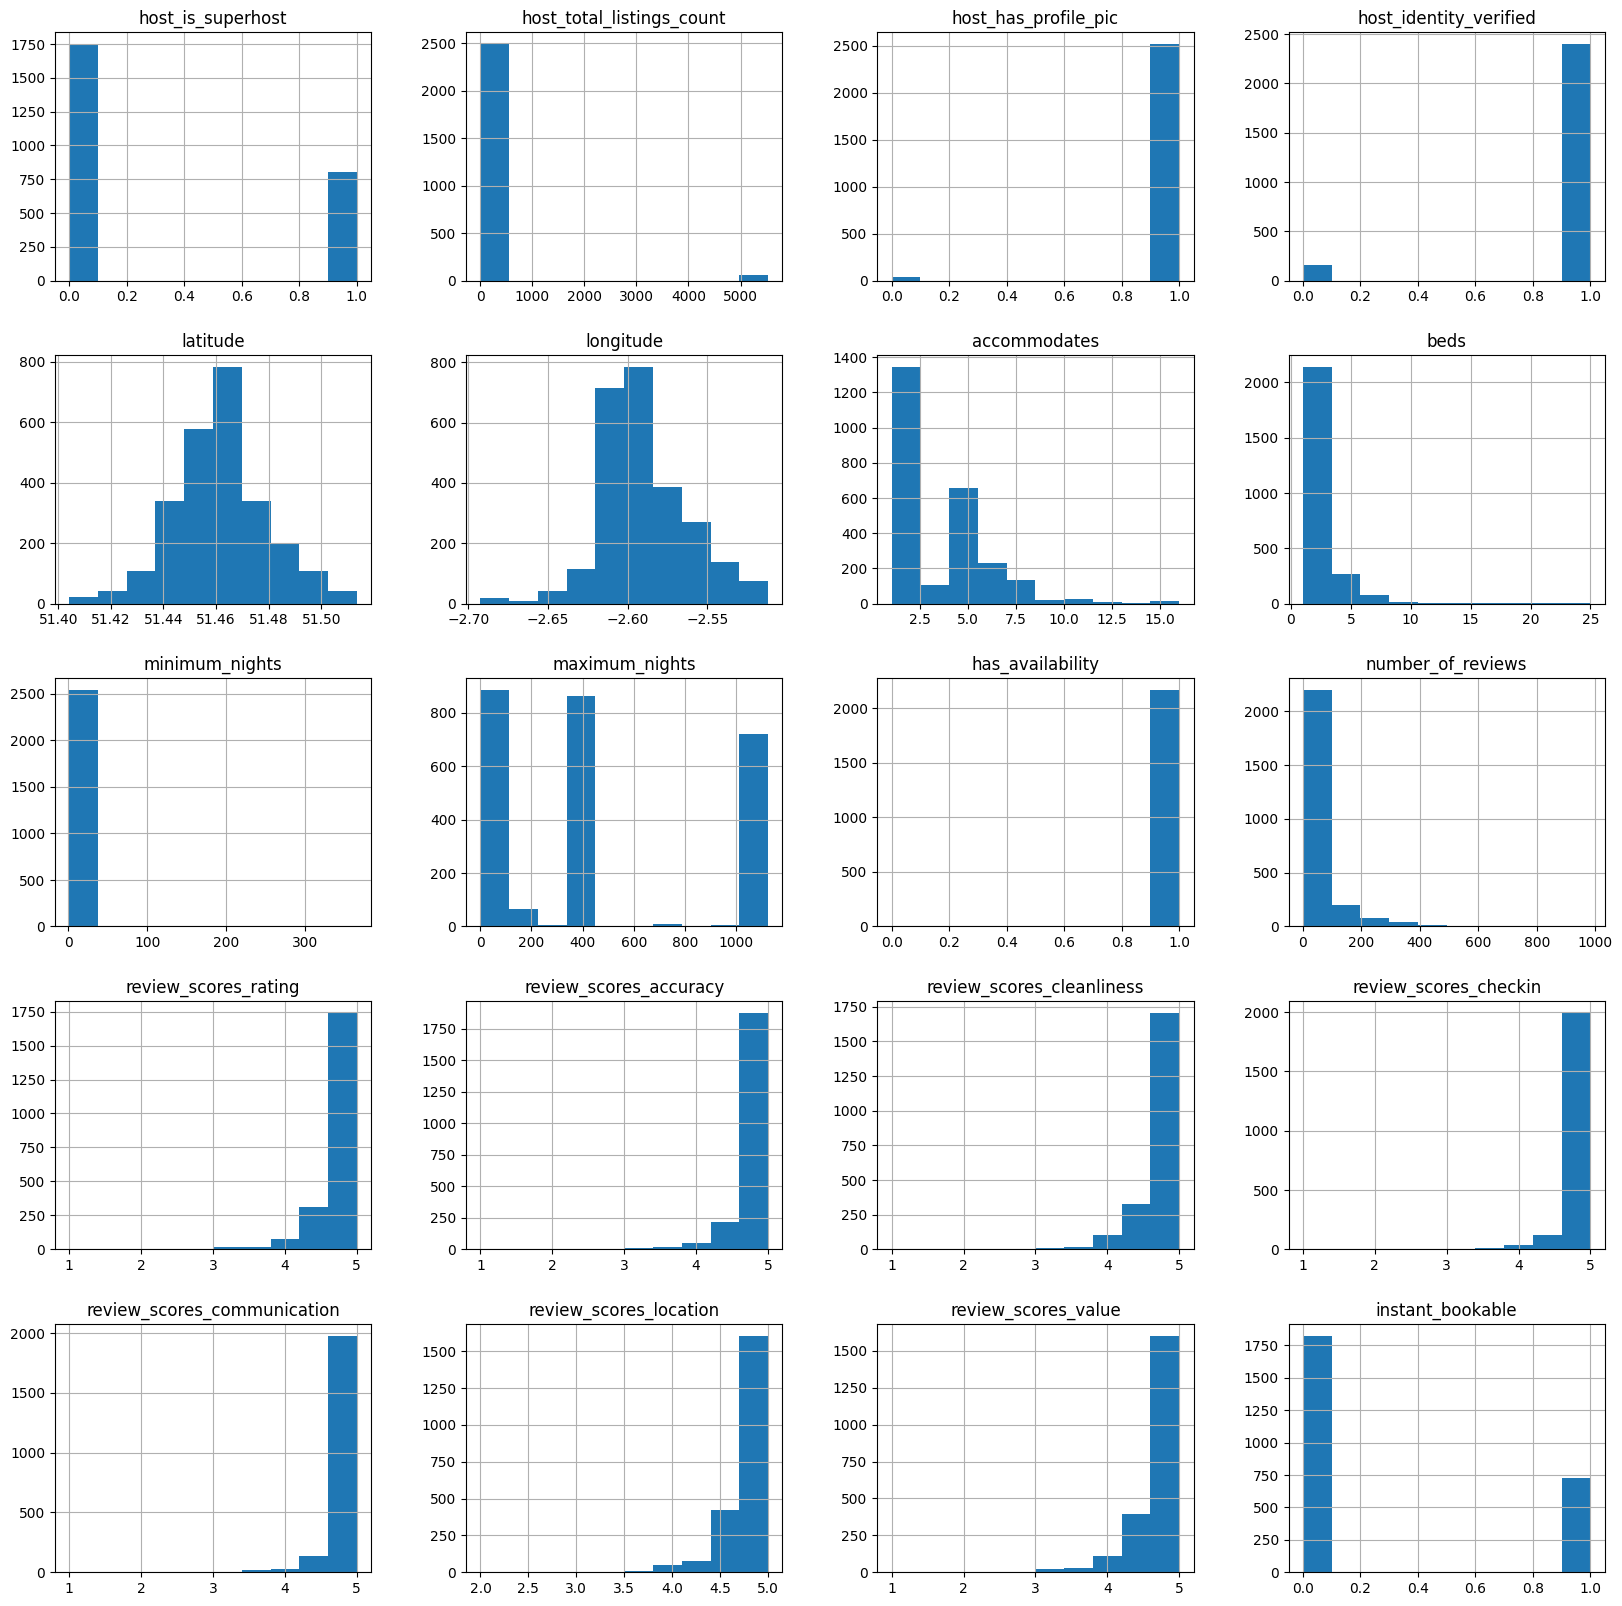

In [8]:
# Replacing columns with f/t with 0/1
AirBnB.replace({'f': 0, 't': 1}, inplace=True)

# Plotting the distribution of numerical and boolean categories
AirBnB.hist(figsize=(20,20));

As shown above, the **minimum_nights** and **has_availability** variables only have one category and can therefore be dropped 

In [9]:
AirBnB = AirBnB.drop(['minimum_nights',
                     'has_availability'], 
                     axis=1)

**Desription of the variables considered:**

- **neighborhood_overview** - Hosts description of the neighbourhood (type = text)
- **host_since** - The date the host/user was created (type = date)
- **host_location** - The hosts self reported location (type = text)
- **host_about** - Description about the host (type = text)
- **host_response_time** - Host response time (type = text)
- **host_response_rate** - Host response rate (type = text)
- **host_acceptance_rate** - Host acceptance rate (type = text)
- **host_is_superhost** - Whether the host is a superhost or not (type = boolean)
- **host_total_listings_count** - The number of listings the host has (type = numeric)
- **host_has_profile_pic** - Whether the host has a profile picture or not (type = boolean)
- **host_identity_verified** - Whether the host has verified their account (type = boolean)
- **latitude** - Latitude WGS84 coordinate of the AirBnB (type = numeric)
- **longitude** - Longitude WGS84 coordinate of the AirBnB (type = numeric)
- **property_type** - Self selected property type (type = text)
- **room_type** - Self selected room type (type = text)
- **accomodates** - The maximum capacity of the listing (type = integer)
- **bathrooms_text** - The number of bathrooms in the listing (type = string)
- **beds** - the number of beds in the listing (type = integer)
- **amenities** - the amenities in the listing (type = json)
- **price** - daily price of the listing in $ (type = currency)
- **maximum_nights** - maximum number of nights stay for the listing (type = integer)
- **number_of_reviews** - The number of reviews the listing has (type = integer)
- **review_scores_rating** - Guests can score properties overall from 1 to 5 stars (type = numeric)
- **review_scores_accuracy** - Guests can score the accuracy of a property's description from 1 to 5 stars (type = numeric)
- **review_scores_cleanliness** - Guests can score a property's cleanliness from 1 to 5 stars (type = numeric)
- **review_scores_checkin** - Guests can score their check-in from 1 to 5 stars (type = numeric)
- **review_scores_communication** - Guests can score a host's communication from 1 to 5 stars (type = numeric)
- **review_scores_location** - Guests can score a property's location from 1 to 5 stars (type = numeric)
- **review_scores_value** - Guests can score a booking's value for money from 1 to 5 stars (type = numeric)
- **instant_bookable** - Whether the guest can automatically book the listing without the host requiring to accept their booking request (type = boolean)

Before any modelling can take place, the data needs cleaning in order to make model building possible

### Cleaning individual columns

**neighbourhood_overview** and **host_about**

These variables had a large amount of NaN values, and if we removed these, the dataset would be heavily reduced. Instead, this variable will be converted from text into numerical 'amount of words' for these descriptions. The theory is that the more descriptive the overview and about sections are, the greater the price, as more effort has been made.

In [10]:
# Creating new variables counting the number of words in 'neighborhood_overview' and 'host_about'
AirBnB['neighborhood_word_count'] = AirBnB['neighborhood_overview'].str.split().str.len()
AirBnB['host_about_word_count'] = AirBnB['host_about'].str.split().str.len()

Where the values are given as NaN for these variables, this means that nothing has been written. This means we can substitute the NaN values for 0

In [11]:
# Replace NaN values in 'neighborhood_word_count' and 'host_about_word_count' columns with 0
AirBnB['neighborhood_word_count'].fillna(0, inplace=True)
AirBnB['host_about_word_count'].fillna(0, inplace=True)

Now that the words have been calculated, the original variables can be removed

In [12]:
AirBnB = AirBnB.drop(['neighborhood_overview',
                      'host_about' ], 
                     axis=1)

**host_location**

As text cannot be added to the model, unless one-hot encoding is used, this variable is converted into binary values. For this variable, we are interested as to whether the host being located in Bristol has an effect on the rental price. To do this, we covert this to Binary, where Bristol is assigned a value of 1 and anything else is given as 0. Any NaN values are changed to 0.

In [13]:
# Defining a function to convert 'Bristol, United Kingdom' to 1 and anything else to 0
def location_to_binary(location):
    if location == 'Bristol, United Kingdom':
        return 1
    else:
        return 0

# Applying the function to the 'host_location' column
AirBnB['host_location_binary'] = AirBnB['host_location'].apply(lambda x: location_to_binary(x))


We can now remove the original variable of 'host_location'

In [14]:
AirBnB = AirBnB.drop(['host_location' ], 
                     axis=1)

**host_response_time**

A fair amount of rows don't have values for **host_response_time** and the majority of these have not been reviewed. Despite this, these datapoints have been retained as they are legitimate properties, with a given letting rate. 

In [15]:
print("Null values:", AirBnB.host_response_time.isna().sum())
print(f"Proportion: {round((AirBnB.host_response_time.isna().sum()/len(AirBnB))*100, 1)}%")

Null values: 451
Proportion: 17.6%


The null values have been changed to its own 'Unknown' category

In [16]:
AirBnB.host_response_time.fillna("unknown", inplace=True)
AirBnB.host_response_time.value_counts(normalize=True)

within an hour        0.609155
unknown               0.176448
within a few hours    0.114632
within a day          0.060642
a few days or more    0.039124
Name: host_response_time, dtype: float64

**host_response_rate** and **host_acceptance_rate**

This variable shows the same trends as the host_response_time, with 17.6%  of values being NaN. This will be kept as its own category. 

In [17]:
print("Null values:", AirBnB.host_response_rate.isna().sum())
print(f"Proportion: {round((AirBnB.host_response_rate.isna().sum()/len(AirBnB))*100, 1)}%")

Null values: 451
Proportion: 17.6%


These variables are given as percentages, and therefore the '%' needs removing in order to convert these columns into numerical values

In [18]:
# Removing the % and converting the 'host_response_rate' column to float
AirBnB['host_response_rate'] = AirBnB['host_response_rate'].str.rstrip('%').astype(float)

print("Mean host response rate:", round(AirBnB['host_response_rate'].mean(),0))
print("Median host response rate:", AirBnB['host_response_rate'].median())
print(f"Proportion of 100% host response rates: {round(((AirBnB.host_response_rate == 100.0).sum()/AirBnB.host_response_rate.count())*100,1)}%")

Mean host response rate: 94.0
Median host response rate: 100.0
Proportion of 100% host response rates: 78.9%


As a large proportion of the hosts respond 100% of the time, these will be kept as its own category and the other values will be grouped into bins. This converts the numerical data to categorical data to make its presence more useful.

In [19]:
# Binning into four categories
AirBnB.host_response_rate = pd.cut(AirBnB.host_response_rate, bins=[0, 50, 90, 99, 100], labels=['0-49%', '50-89%', '90-99%', '100%'], include_lowest=True)

# Converting to string
AirBnB.host_response_rate = AirBnB.host_response_rate.astype('str')

# Replacing NaN values with 'unknown'
AirBnB.host_response_rate.replace('nan', 'unknown', inplace=True)

# Category counts
AirBnB.host_response_rate.value_counts()

100%       1661
unknown     451
90-99%      165
50-89%      159
0-49%       120
Name: host_response_rate, dtype: int64

Repeating the same process for **host_acceptance_rate**

In [20]:
AirBnB['host_acceptance_rate'] = AirBnB['host_acceptance_rate'].astype(str)
AirBnB['host_acceptance_rate'] = AirBnB['host_acceptance_rate'].str.rstrip('%').astype(float)

print("Mean host acceptance rate:", round(AirBnB['host_acceptance_rate'].mean(),0))
print("Median host acceptance rate:", AirBnB['host_acceptance_rate'].median())
print(f"Proportion of 100% host acceptance rates: {round(((AirBnB.host_acceptance_rate == 100.0).sum()/AirBnB.host_acceptance_rate.count())*100,1)}%")

Mean host acceptance rate: 87.0
Median host acceptance rate: 98.0
Proportion of 100% host acceptance rates: 33.6%


The bins have been grouped in the same manner as **host_response_rate** for consistency

In [21]:
AirBnB['host_acceptance_rate'] = pd.cut(AirBnB['host_acceptance_rate'], bins=[0, 50, 90, 99, 100], labels=['0-49%', '50-89%', '90-99%', '100%'], include_lowest=True)
AirBnB['host_acceptance_rate'] = AirBnB['host_acceptance_rate'].astype('str')
AirBnB['host_acceptance_rate'].replace('nan', 'unknown', inplace=True)
AirBnB['host_acceptance_rate'].value_counts()

90-99%     864
100%       787
50-89%     503
unknown    216
0-49%      186
Name: host_acceptance_rate, dtype: int64

**host_is_superhost**

Although only two NaN values are present, these have been changed to '0' to suggest that these are not superhosts, otherwise it is likely that this would have been higlighted. 

In [22]:
AirBnB['host_is_superhost'] = AirBnB['host_is_superhost'].fillna(0)

**property_type**

Cleaning of property types is required. The categories 'apartment', 'house' and 'other' will be used, as most properties can be classified as either apartments or houses.

In [23]:
AirBnB.property_type.value_counts()

Entire rental unit                    726
Entire home                           486
Private room in home                  422
Entire condo                          241
Private room in rental unit           151
Entire serviced apartment             105
Private room in townhouse              93
Private room in condo                  71
Entire townhouse                       68
Private room in bed and breakfast      40
Entire guest suite                     17
Tiny home                              15
Entire guesthouse                      14
Room in serviced apartment             11
Entire cottage                         10
Entire loft                             9
Private room                            8
Camper/RV                               8
Entire villa                            7
Private room in guest suite             6
Private room in tiny home               6
Entire place                            4
Entire cabin                            4
Shared room in rental unit        

In [24]:
# Replacing categories that are types of houses or apartments
AirBnB.property_type.replace({
    'Entire home': 'House',
    'Entire condo': 'Apartment',
    'Entire serviced apartment': 'Apartment',
    'Entire townhouse': 'House',
    'Tiny home': 'House',
    'Entire guesthouse': 'House',
    'Entire cottage': 'House',
    'Entire loft': 'Apartment',
    'Entire villa': 'House',
    'Entire cabin': 'House',
    'Entire vacation home': 'House',
    'Entire bungalow': 'House',
    }, inplace=True)

# Replacing other categories with 'other'
AirBnB.loc[~AirBnB.property_type.isin(['House', 'Apartment']), 'property_type'] = 'Other'

In [25]:
AirBnB.property_type.value_counts()

Other        1595
House         606
Apartment     355
Name: property_type, dtype: int64

**room_type**

This can be kept as it is, as there an no NaN values

In [26]:
AirBnB.room_type.value_counts()

Entire home/apt    1722
Private room        817
Hotel room           13
Shared room           4
Name: room_type, dtype: int64

**beds**

Missing values will be replaced with the median. This is to avoid removing a large proportion of the dataset.

In [27]:
for col in ['beds']:
    AirBnB[col].fillna(AirBnB[col].median(), inplace=True)

**bathrooms_text**

The current bathroom data is given as text data and therefore this needs to be converted to numerical data, instead of being one-hot encoded

In [28]:
AirBnB.bathrooms_text.value_counts()

1 bath              1248
1 shared bath        300
2 baths              243
1 private bath       222
1.5 baths            203
1.5 shared baths     111
2.5 baths             89
3 baths               50
2 shared baths        25
3.5 baths             18
Half-bath             10
5 baths                7
Shared half-bath       5
4.5 baths              5
2.5 shared baths       4
4 baths                4
3 shared baths         2
7 baths                2
0 shared baths         2
6 baths                2
0 baths                2
15 baths               1
Name: bathrooms_text, dtype: int64

In [29]:
# Converting text to numerical values
AirBnB.bathrooms_text.replace({
    '1 bath': '1',
    '1 shared bath': '1',
    '2 baths': '2',
    '1 private bath': '1',
    '1.5 baths': '1.5',
    '1.5 shared baths': '1.5',
    '2.5 baths': '2.5',
    '3 baths': '3',
    '2 shared baths': '2',
    '3.5 baths': '3.5',
    'Half-bath': '0.5',
    '5 baths': '5',
    'Shared half-bath': '0.5',
    '4.5 baths': '4.5',
    '2.5 shared baths': '2.5',
    '4 baths': '4',
    '3 shared baths': '3',
    '7 baths': '7',
    '0 shared baths': '0',
    '6 baths': '6',
    '0 baths': '0',
    '15 baths': '15'
}, inplace=True)

# Convert to float
AirBnB['bathrooms_text'] = AirBnB['bathrooms_text'].astype(float)

In [30]:
AirBnB.bathrooms_text.value_counts()

1.0     1770
1.5      314
2.0      268
2.5       93
3.0       52
3.5       18
0.5       15
5.0        7
4.5        5
0.0        4
4.0        4
7.0        2
6.0        2
15.0       1
Name: bathrooms_text, dtype: int64

The **bathrooms_text** data had 1 NaN value and therefore this is replaced with the median

In [31]:
for col in ['bathrooms_text']:
    AirBnB[col].fillna(AirBnB[col].median(), inplace=True)

Considering the data is no longer text data, it makes sense to rename the variable to improve clarity

In [32]:
AirBnB.rename(columns={'bathrooms_text': 'bathrooms'}, inplace=True)

**amenities**

In [33]:
AirBnB.amenities.head

<bound method NDFrame.head of 0       []
1       []
2       []
3       []
4       []
        ..
2551    []
2552    []
2553    []
2554    []
2555    []
Name: amenities, Length: 2556, dtype: object>

Unfortunately, no amenities data is provided and therefore this variable is removed from the dataset.

In [34]:
AirBnB = AirBnB.drop(['amenities'], 
                     axis=1)

**host_since**

Instead of working with date data, these dates are converted into the number of days since the host created their account

Please note, that the date in which these days refer to has been fixed to ensure reproducibility. The date in which this code was written has been used.

In [35]:
# Defining a constant date for reproducibility
present_day = datetime.datetime(2024, 5, 19)

# Converting 'host_since' column to datetime format
AirBnB['host_since'] = pd.to_datetime(AirBnB['host_since'])

# Calculating the number of days since the account was created 
AirBnB['days_since_creation'] = (present_day - AirBnB['host_since']).dt.days

# Verifying the changes by displaying the first few rows of 'host_since' and 'days_since_creation' columns
print(AirBnB[['host_since', 'days_since_creation']].head())


  host_since  days_since_creation
0 2011-01-24                 4864
1 2011-05-15                 4753
2 2011-06-16                 4721
3 2012-01-08                 4515
4 2012-03-18                 4445


This has generated a new variable named **days_since_creation**, and therefore the **host_since** variable can be removed

In [36]:
AirBnB = AirBnB.drop(['host_since'], 
                     axis=1)

**price**

In [37]:
# Counting the number of NaN values in the 'price' column
price_nan_count = AirBnB['price'].isnull().sum()

# Print the result
print("Number of NaN values in 'price' column:", price_nan_count)


Number of NaN values in 'price' column: 387


Considering that price is what we are predicting, these are removed 

In [38]:
# Removing rows with NaN values in the 'price' column
AirBnB = AirBnB.dropna(subset=['price'])
AirBnB.shape

(2169, 29)

In order to predict price numerically, the '$' needs be removed

In [39]:
AirBnB.price = AirBnB.price.str[1:-3]
AirBnB.price = AirBnB.price.str.replace(",", "")
AirBnB.price = AirBnB.price.astype('int64')

**latitude** and **longitude**

This data will be used to calculate the distance (km) of the AirBnB to the city centre

In [40]:
def haversine(lat1, lon1, lat2, lon2):
    # Radius of the Earth in kilometers
    R = 6371.0
    
    # Convert latitude and longitude from degrees to radians
    lat1 = math.radians(lat1)
    lon1 = math.radians(lon1)
    lat2 = math.radians(lat2)
    lon2 = math.radians(lon2)
    
    # Calculate differences in latitude and longitude
    dlat = lat2 - lat1
    dlon = lon2 - lon1
    
    # Calculate Haversine formula
    a = math.sin(dlat / 2)**2 + math.cos(lat1) * math.cos(lat2) * math.sin(dlon / 2)**2
    c = 2 * math.atan2(math.sqrt(a), math.sqrt(1 - a))
    
    # Calculate the distance
    distance = R * c
    
    return distance


Applying this function to all AirBnBs

In [41]:
# Coordinates of Bristol city centre
city_centre_lat = 51.4545
city_centre_lon = -2.5879

# Calculate the distance for each AirBnB location
AirBnB['distance_to_city_centre'] = AirBnB.apply(lambda row: haversine(city_centre_lat, city_centre_lon, row['latitude'], row['longitude']), axis=1)


In [42]:
AirBnB.distance_to_city_centre.head

<bound method NDFrame.head of 0       1.807539
1       1.619542
2       1.761753
3       2.437698
4       2.365036
          ...   
2551    1.305660
2552    3.643064
2553    1.171809
2554    3.279551
2555    0.800647
Name: distance_to_city_centre, Length: 2169, dtype: float64>

Given that we now have the distance from the city centre, we cn remove the latitude and longitude values

In [43]:
AirBnB = AirBnB.drop(['latitude',
                     'longitude'], 
                     axis=1)

**reviews**

A large amount of reviews have NaN values, which is too significant for them to be removed from the dataset. By dropping these columns, a lot of useful information would be lost. 

It is not possible to apply values to these NaNs, as this would skew the data considerably. Instead, the decision has been made to group these NaN values into an 'Unknown' category. This means that the rest of the data is converted from numerical to categorical, and one-hot encoding is used.

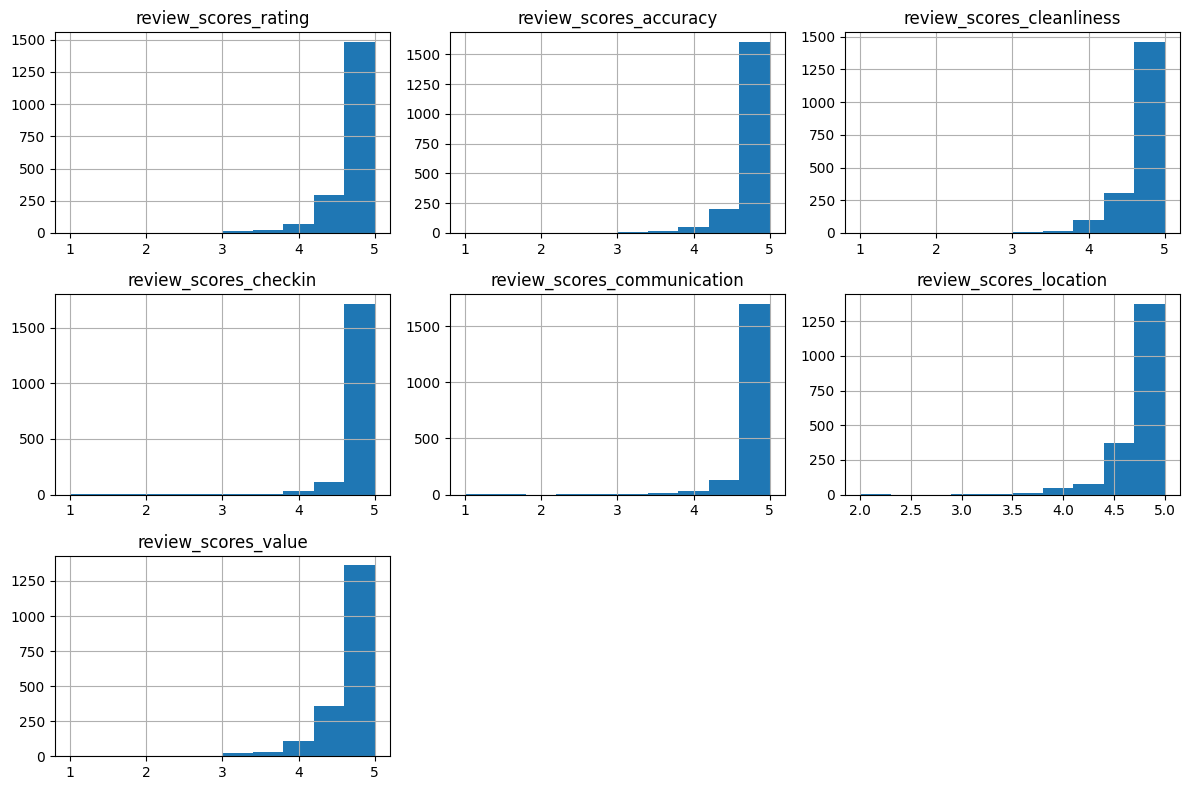

In [44]:
# Checking the distributions of all the review columns
reviews_plot = list(AirBnB.columns[AirBnB.columns.str.startswith("review_scores") == True])
fig = plt.figure(figsize=(12,8))
for i, var_name in enumerate(reviews_plot):
    ax = fig.add_subplot(3,3,i+1)
    AirBnB[var_name].hist(bins=10,ax=ax)
    ax.set_title(var_name)
fig.tight_layout()
plt.show()

In [45]:
def bin_column(col, bins, labels, na_label='unknown'):
    """
    Takes in a column name, bin cut points and labels, replaces the original column with a
    binned version, and replaces nulls (with 'unknown' if unspecified).
    """
    AirBnB[col] = pd.cut(AirBnB[col], bins=bins, labels=labels, include_lowest=True)
    AirBnB[col] = AirBnB[col].astype('str')
    AirBnB[col].fillna(na_label, inplace=True)


The distributions of the reviews show a majority of values between 4 and 5. As a result, 4/5 and 5/5 have been kept as seperate groups, with values from 0-3 being binned together. Any NaN values will be grouped as 'unknown'

In [46]:
# Binning all the review columns
for col in reviews_plot:
    bin_column(col,
               bins=[0, 3, 4, 5],
               labels=['0-3/5', '4/5', '5/5'],
               na_label='no reviews')

In [47]:
AirBnB.review_scores_rating.value_counts()

5/5      1806
nan       280
4/5        66
0-3/5      17
Name: review_scores_rating, dtype: int64

The nan shows the Unknown review types

Now that we have processed the data, we can have a look at the correlation matrix of variables

First, the categorical variables need to be one-hot encoded

In [48]:
transformed_AirBnB = pd.get_dummies(AirBnB)

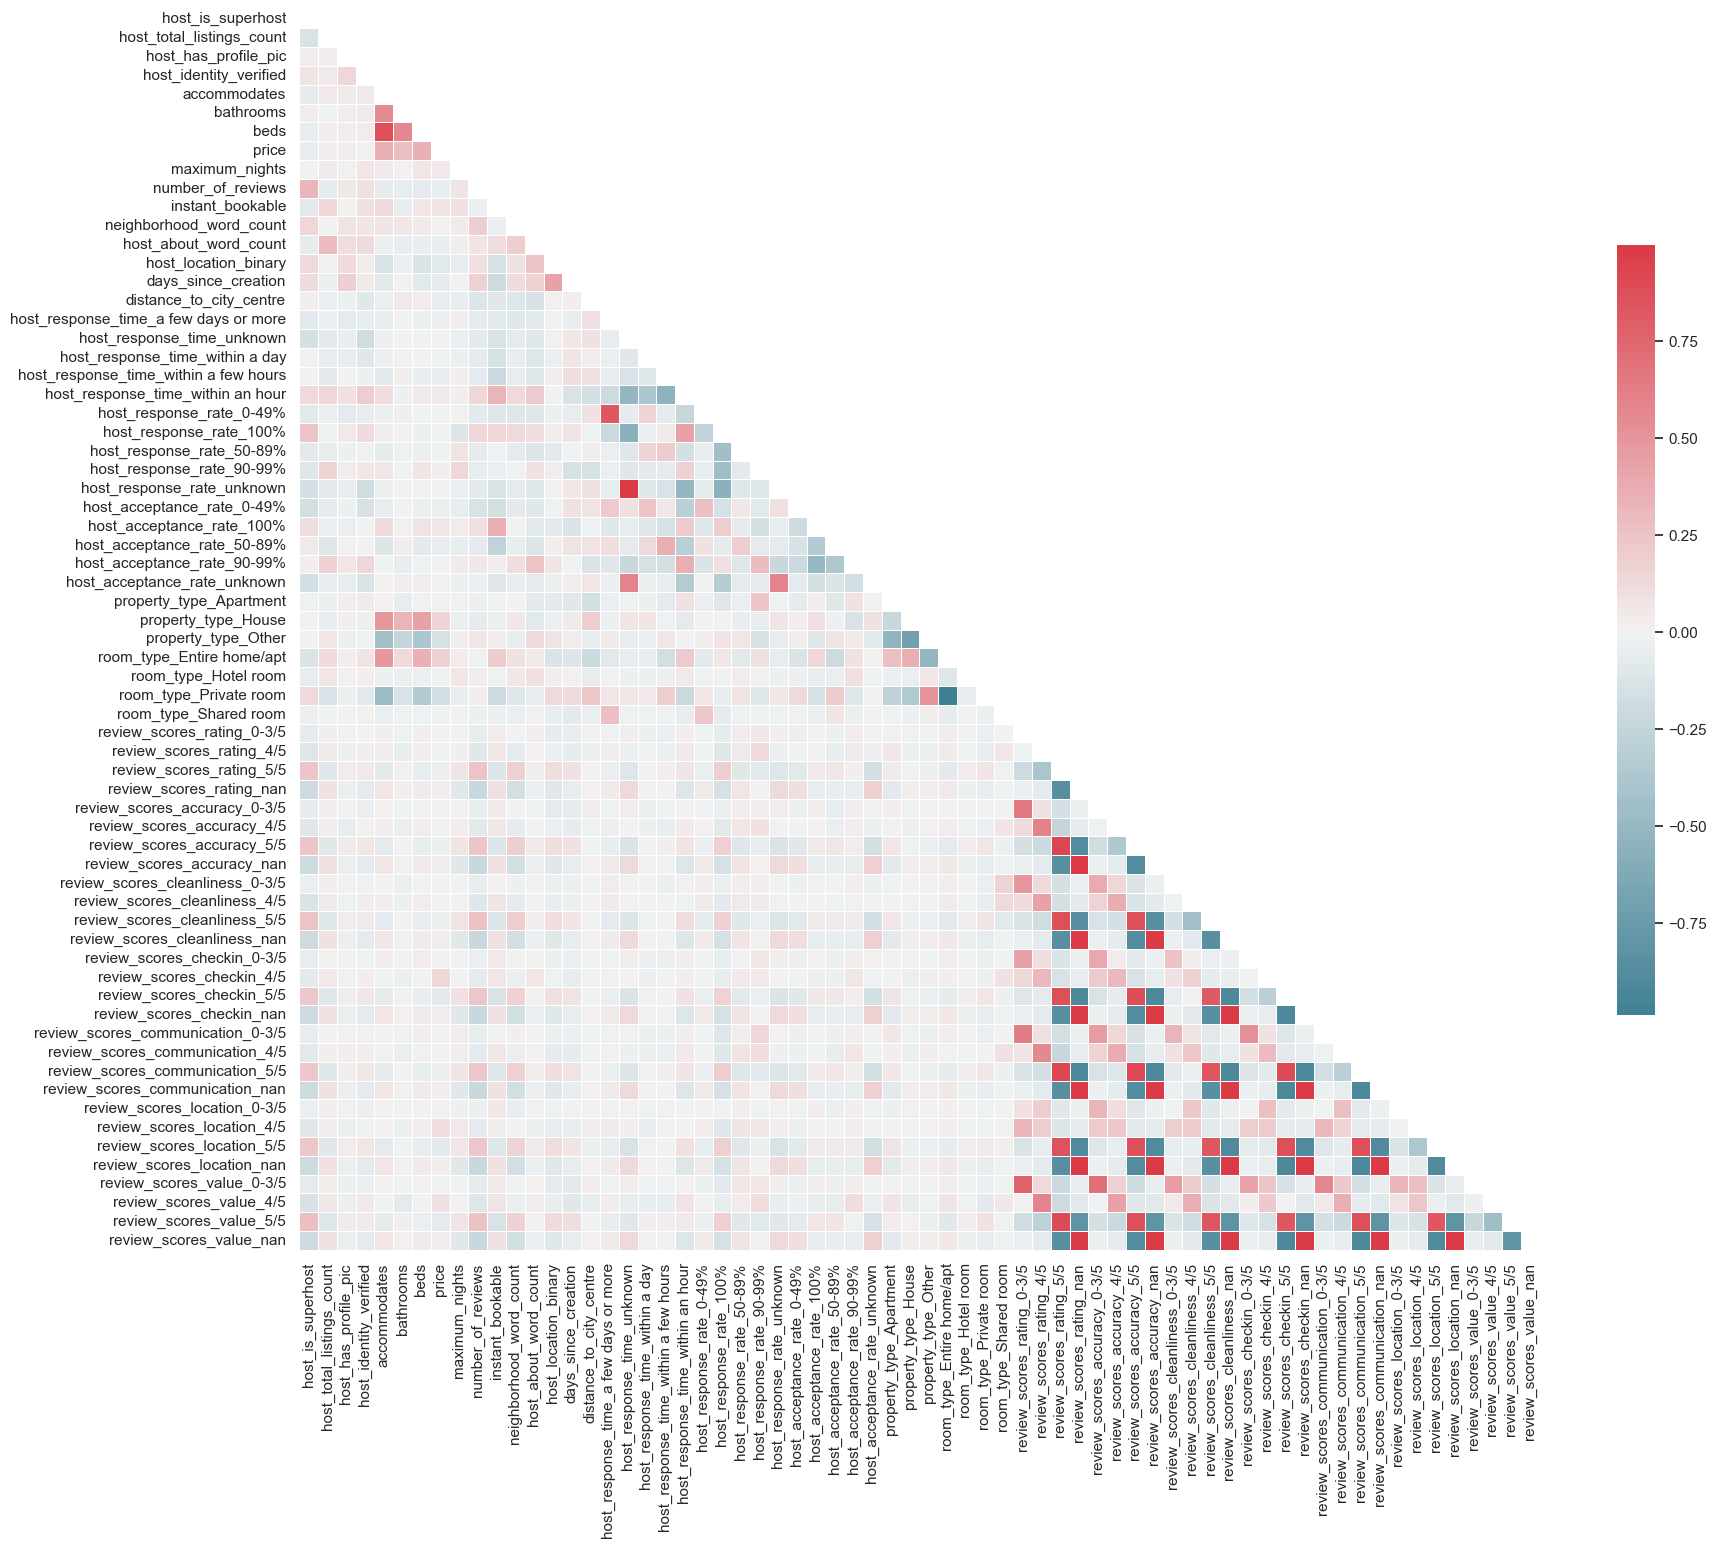

In [49]:
def multi_collinearity_heatmap(df, figsize=(11,9)):
    """
    Creates a heatmap of correlations between features in the dataframe. A figure size can optionally be set.
    """
    # Setting the style of the visualization
    sns.set(style="white")

    # Creating a covariance matrix
    corr = df.corr()

    # Generating a mask the size of our covariance matrix
    mask = np.zeros_like(corr, dtype=bool)  
    mask[np.triu_indices_from(mask)] = True

    # Set up the matplotlib figure
    f, ax = plt.subplots(figsize=figsize)

    # Generating a custom diverging colormap
    cmap = sns.diverging_palette(220, 10, as_cmap=True)

    # Drawing the heatmap with the mask and correct aspect ratio
    sns.heatmap(corr, mask=mask, cmap=cmap, center=0, square=True, linewidths=.5, cbar_kws={"shrink": .5}, vmax=corr[corr != 1.0].max().max());

#Plotting the multi-collinearity heat map
multi_collinearity_heatmap(transformed_AirBnB, figsize=(20,20))


- Clear areas of multicollinearity is shown between the review scores. For now, these are left in the dataset, but further exploration will consider whether their removal will improve model predictions

- Beds and the amount of people that the property can accomodate also display high multi-collinearity. The number of people to be accomodated is more relevant and therefore the beds variable is removed.

- The **host_response_rate_0-49%** also has high collinearity with **host_response_time_a_few_days_or_more**. This makes sense, and one of these will be dropped.

- The unknown response rate and the unknown response time also displays high multi-collinearity so these are both removed.

- There are strong negative correlations between private rooms and entire homes/apartments, as well as between apartments, houses and other property types. Although these are important, one of each will be dropped in order to reduce multi-collinearity. Private rooms and apartments are dropped as these are the second most common


In [50]:
# Dropping collinear features
to_drop = ['host_acceptance_rate_unknown',
           'host_response_rate_unknown',
           'beds',
           'host_response_rate_0-49%',
          'property_type_Apartment',
          'room_type_Private room']
to_drop.extend(list(transformed_AirBnB.columns[transformed_AirBnB.columns.str.endswith('nan')]))

transformed_AirBnB.drop(to_drop, axis=1, inplace=True)

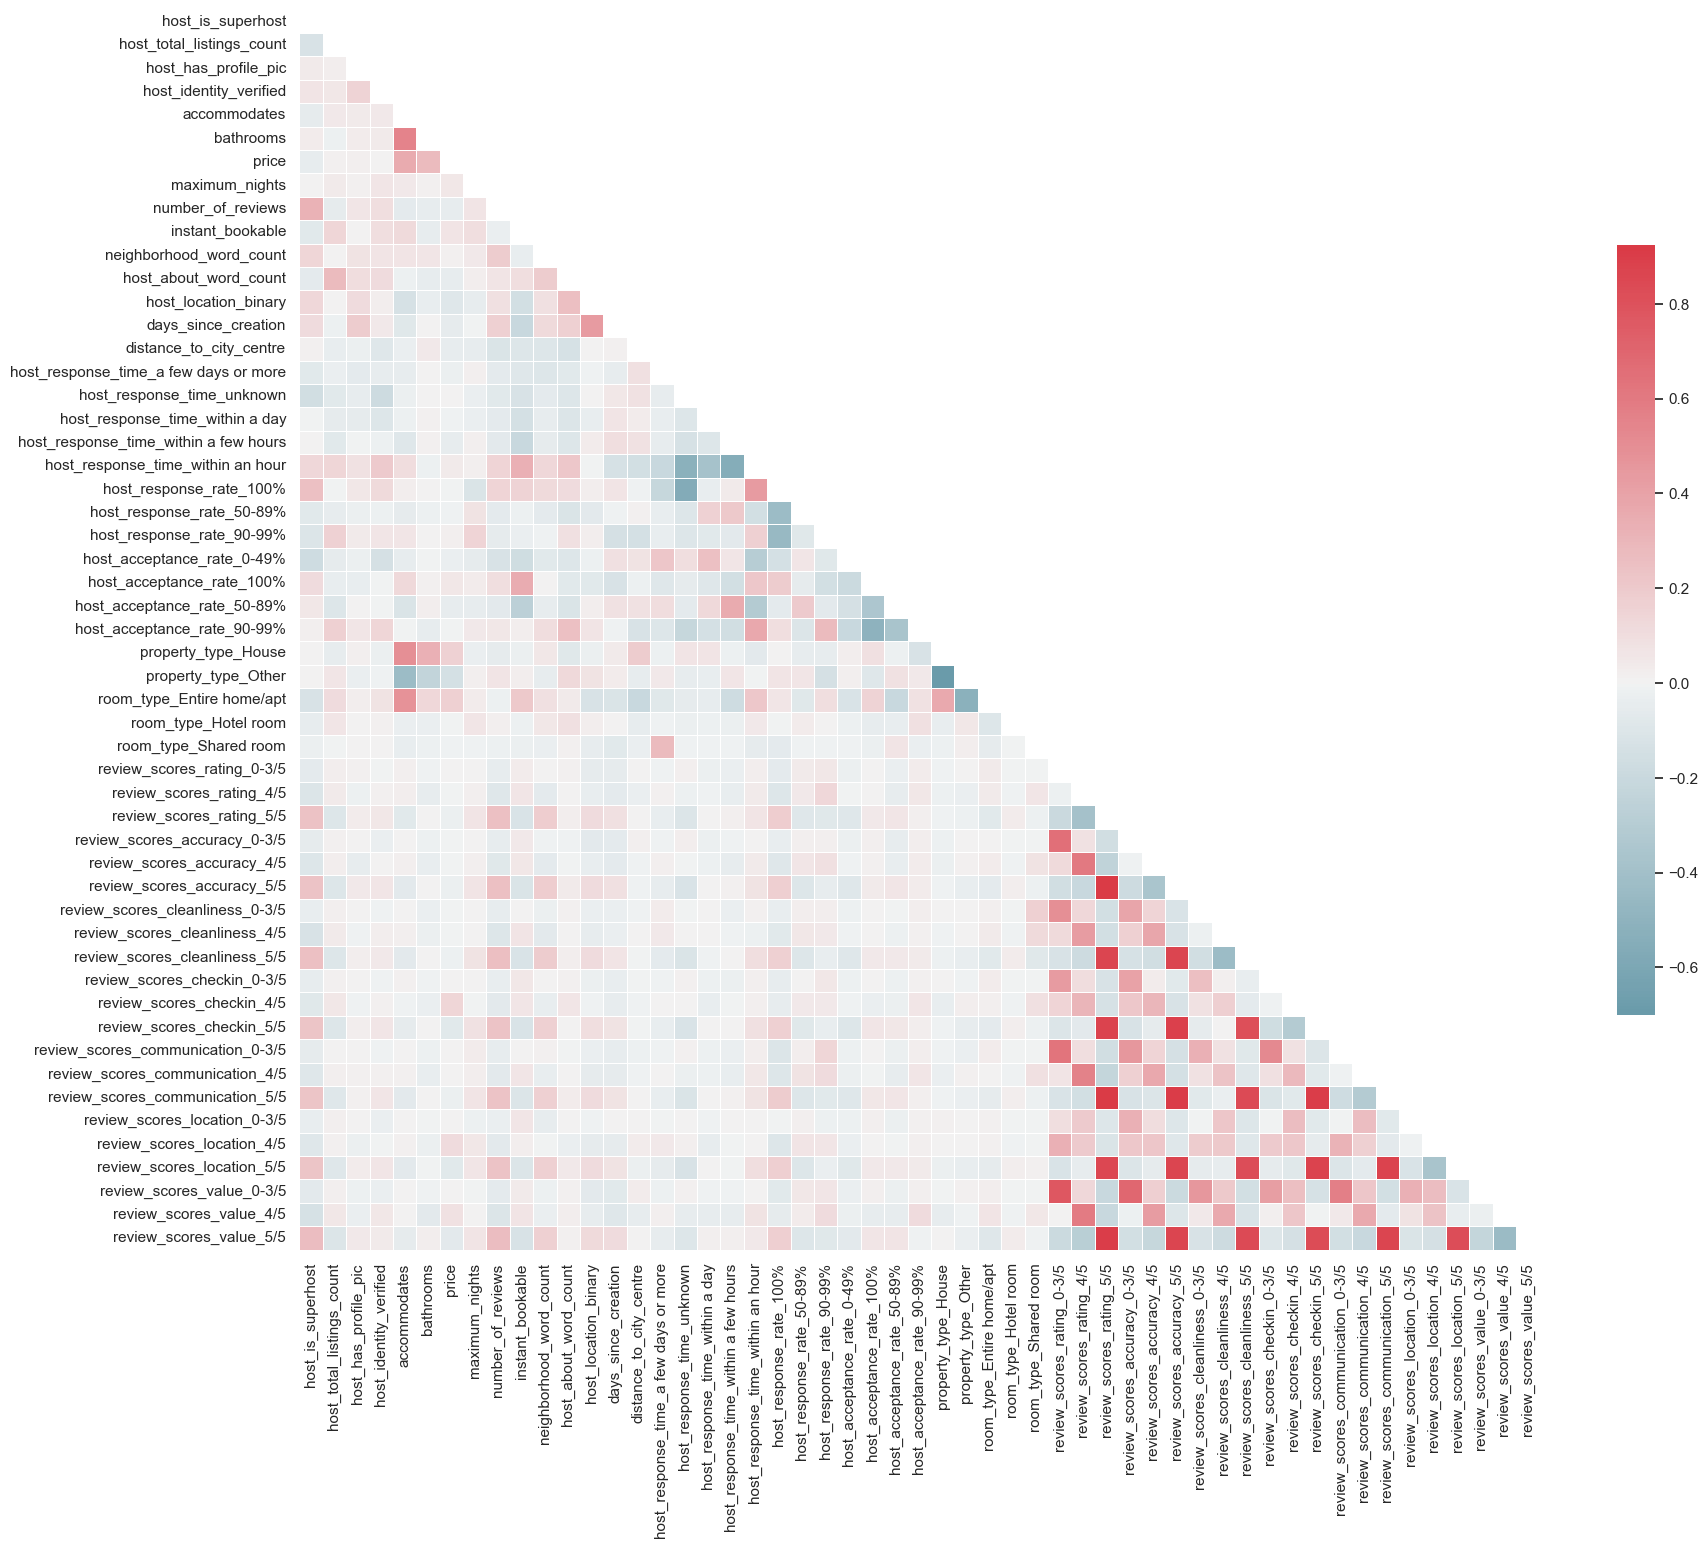

In [51]:
#Assessing the collinearity with these features removed
multi_collinearity_heatmap(transformed_AirBnB, figsize=(20,20))

There are still strong correlations, especially between highly rated properties. For example, if a property gets a 5/5 review score overall, it is likely to score highly over the review categories.

The decision has been made to leave these variables in the dataset for now, and their effect on the model will be experimented later

**Standardizing and normalising the variables**

This is an important step, to ensure that certain variables do not disproportiantely influence the results. This is only required for the numerical variable, so these are explored

In [52]:
#Grouping the numerical variables
numerical_columns = ['host_total_listings_count', 
                     'accommodates', 
                     'bathrooms', 
                     'price', 
                     'maximum_nights', 
                     'number_of_reviews', 
                     'neighborhood_word_count', 
                     'host_about_word_count', 
                     'days_since_creation', 
                     'distance_to_city_centre']

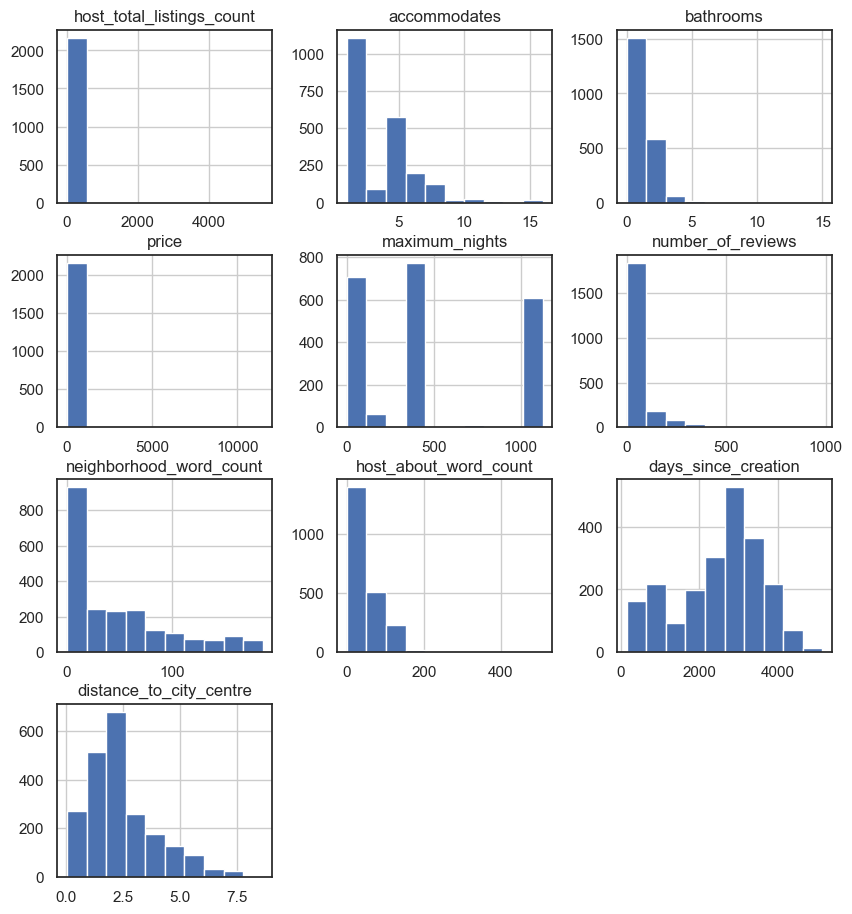

In [53]:
#Plotting the distribution of values for each variable
transformed_AirBnB[numerical_columns].hist(figsize=(10,11));

Apart from **days_since_creation** and **maximum_nights**, the remaining variables appear positively skewed, and could benefit from having a log transformation applied

In [54]:
# Log transforming columns
numerical_columns = [i for i in numerical_columns if i not in ['days_since_creation', 'maximum_nights']] 
for col in numerical_columns:
    transformed_AirBnB[col] = transformed_AirBnB[col].astype('float64').replace(0.0, 0.01) # Replacing 0s with 0.01
    transformed_AirBnB[col] = np.log(transformed_AirBnB[col])

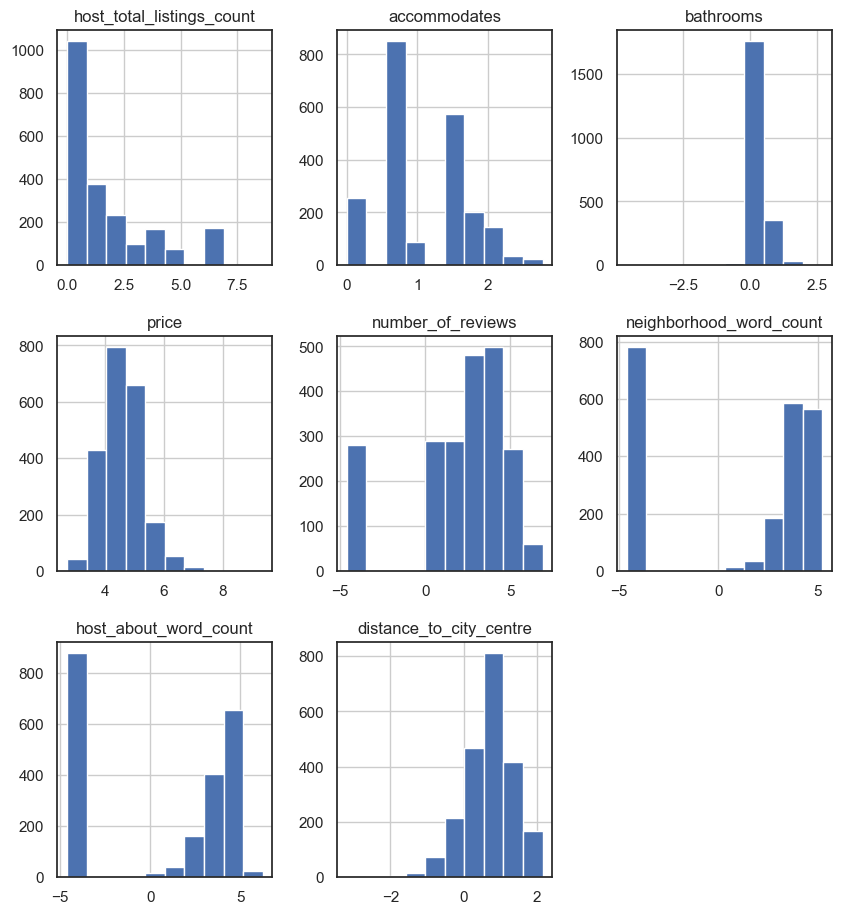

In [55]:
transformed_AirBnB[numerical_columns].hist(figsize=(10,11));

Some distributions have benefitted from this transformation. Some features contain a large amount of 0's and therefore the data is not normally distributed (ie. **neighborhood_word_count**). The price variable is now normally distributed, which is the most important thing, as this is the target variable.  

The X variables can now be seperated from the target y feature (price). 

In [56]:
# Separating the X and y variables
X = transformed_AirBnB.drop('price', axis=1)
y = transformed_AirBnB.price

# Standardizing the X variables
scaler = StandardScaler()
X = pd.DataFrame(scaler.fit_transform(X), columns=list(X.columns))

In [57]:
nan_counts = transformed_AirBnB.isna().sum()
print(nan_counts)


host_is_superhost                        0
host_total_listings_count                0
host_has_profile_pic                     0
host_identity_verified                   0
accommodates                             0
bathrooms                                0
price                                    0
maximum_nights                           0
number_of_reviews                        0
instant_bookable                         0
neighborhood_word_count                  0
host_about_word_count                    0
host_location_binary                     0
days_since_creation                      0
distance_to_city_centre                  0
host_response_time_a few days or more    0
host_response_time_unknown               0
host_response_time_within a day          0
host_response_time_within a few hours    0
host_response_time_within an hour        0
host_response_rate_100%                  0
host_response_rate_50-89%                0
host_response_rate_90-99%                0
host_accept

Following the data cleaning, normalisation and standardization processes, the dataframe contains no NaN values and therefore the model fitting can take place.

## Building a neural network

Several deep and machine learning models will be built in order to predict an AirBnB listings price.

This research is based around lowering the MSE and therefore this will be the evaluation metric used. The r-squared value will also be provided for each model.

Firstly, the data is split into test and training datasets. 20% of the data is left for testing.

In [58]:
# Splitting into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, 
                                                    y, 
                                                    test_size=0.2, 
                                                    random_state=1)

### Model 1: XGBoost Regressor

Before constructing neural networks, an XGBoost Regressor model is implemented, to establish a baseline MSE and to understand the faeture importance. This model type is used specifically as it is likely to deliver the highest accuracy achievable with machine learning models.

In [59]:
# Initializing the XGBoost regressor model
model1_xgb = xgb.XGBRegressor()

# Fiting the model to the training data
model1_xgb.fit(X_train, y_train)

# Predicting the target values for the training data
training_preds_model1_xgb = model1_xgb.predict(X_train)

# Predicting the target values for the test data
val_preds_model1_xgb = model1_xgb.predict(X_test)

# Printing the Mean Squared Error (MSE) for the training data
print("\nTraining MSE:", round(mean_squared_error(y_train, training_preds_model1_xgb),4))

# Printing the Mean Squared Error (MSE) for the test data
print("Validation MSE:", round(mean_squared_error(y_test, val_preds_model1_xgb),4))

# Printing the R-squared (r2) score for the training data
print("\nTraining r2:", round(r2_score(y_train, training_preds_model1_xgb),4))

# Printing the R-squared (r2) score for the test data
print("Validation r2:", round(r2_score(y_test, val_preds_model1_xgb),4))



Training MSE: 0.004
Validation MSE: 0.1314

Training r2: 0.9917
Validation r2: 0.6891


The extremely low MSE for the training data shows that the XGBoost performs really well on the training data. However, there is a clear overfitting problem in this model, as the MSE is much larger for the validation dataset. This shows that the model is focusing too much on the noise and missing underling patterns.

In [60]:
# Creating a DataFrame to store feature importances from the trained model
model1_xgb_weights = pd.DataFrame(model1_xgb.feature_importances_, columns=['weight'], index=X_train.columns)

# Sorting the importances in ascending order
model1_xgb_weights.sort_values('weight', inplace=True)

# Displaying the DataFrame 
model1_xgb_weights


,weight
review_scores_location_0-3/5,0.000000
review_scores_rating_0-3/5,0.000000
review_scores_value_0-3/5,0.000221
review_scores_communication_4/5,0.000532
review_scores_checkin_0-3/5,0.000709
review_scores_location_5/5,0.000974
room_type_Hotel room,0.001080
host_acceptance_rate_90-99%,0.002038
host_has_profile_pic,0.002303
review_scores_accuracy_0-3/5,0.002606


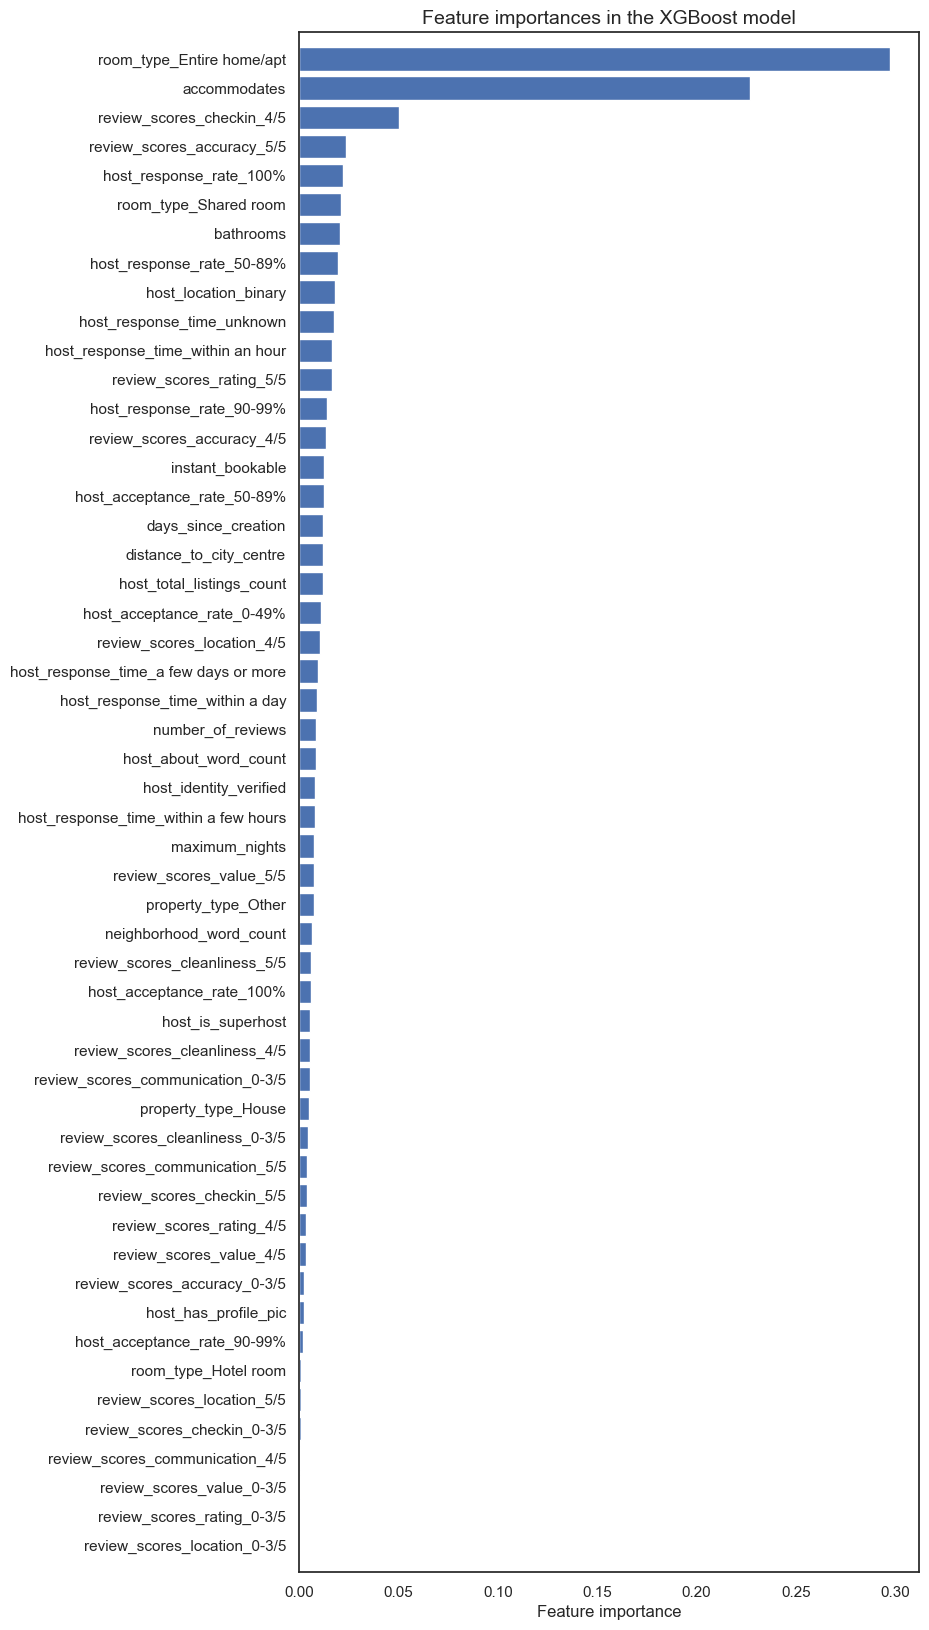

In [61]:
# Plotting these feature importances
plt.figure(figsize=(8,20))
plt.barh(model1_xgb_weights.index, model1_xgb_weights.weight, align='center') 
plt.title("Feature importances in the XGBoost model", fontsize=14)
plt.xlabel("Feature importance")
plt.margins(y=0.01)
plt.show()

Two of the variables have a feature importance of 0. These could potentially be removed, however this has not been undertaken as they could interact with other variables 

**The top 10 most important features are:**

1. Having the entire property - **room_type_Entire home/apt**
2. How many people the property accomodates - **accomodates**
3. A check-in review score of 4/5 - **review_scores_checkin_4/5**
4. An accuracy review score of 5/5 - **review_scores_accuracy_5/5**
5. A host response rate of 100% - **host_response_rate_100%**
6. A shared room type - **room_type_Shared room** 
7. The number of bathrooms - **bathrooms**
8. A host response rate between 50-89% - **host_response_rate_50-89%**
9. The location of the host - **host_location_binary**
10. An unknown response time from the host - **host_response_time_unknown**


Looking at these variables, it is understandable that the room type and the amount of people the property accomodates are significant factors, as these are what customers would be originally searching for.

It is also not suprising that fast response rates/times alongside well-rated properties are important for determining the listing price of an AirBnB

The most suprising feature is that the unknown response time has made it in to the top 10. This is likely correlated to ther variables as it is slightly concerning that NaN values have a significant weighting for determining listing prices.

**Model 2 - Neural Network with three layers**

In an attempt to improve on the MSE scores, a three-layer NN will be created. The model will consist of densely-connected layers, utilizing the ReLU activation function for the hidden layers to introduce non-linearity. The output layer will use a linear activation function. The MSE is used measure the prediction error, and the SGD (Stochastic Gradient Descent) optimizer will be employed to minimize the loss during training.

In [62]:
# Setting the seed for reproducibility
seed = 1
random.seed(seed)
np.random.seed(seed)
tf.random.set_seed(seed)

# Building the model
model2_3lnn = models.Sequential()  # Initializing a sequential model
model2_3lnn.add(layers.Dense(128, input_shape=(X_train.shape[1],), activation='relu'))  # Adding first layer with 128 units and ReLU activation
model2_3lnn.add(layers.Dense(256, activation='relu'))  # Adding second layer with 256 units and ReLU activation
model2_3lnn.add(layers.Dense(256, activation='relu'))  # Adding third layer with 256 units and ReLU activation
model2_3lnn.add(layers.Dense(1, activation='linear'))  # Adding output layer with 1 unit and linear activation

# Compiling the model 
model2_3lnn.compile(loss='mean_squared_error',  # MSE
                    optimizer='SGD',  # Using the SGD optimizer
                    metrics=['mean_squared_error'])  # Evaluating the model

# Model summary
print(model2_3lnn.summary())



/Users/olivermorgan/anaconda3/lib/python3.11/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense (Dense)                   │ (None, 128)            │         6,784 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 256)            │        33,024 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 256)            │        65,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 1)              │           257 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 105,857 (413.50 KB)

 Trainable params: 105,857 (413.50 KB)

 Non-trainable params: 0 (0.00 B)

None


For the first model, a number of batch and epoch sizes are explored in an attempt to find the optimum conditions. 

In [63]:
# Parameters to test
batch_sizes = [32, 64, 128, 256]
epochs_list = [20, 30, 50, 100, 200]

# Dictionary to store results
results = {}

# Looping through different batch sizes and epochs
for batch_size in batch_sizes:
    for epochs in epochs_list:
        print(f'Training with batch size: {batch_size} and epochs: {epochs}')
        
        
        # Training the model
        model2_3lnn_history = model2_3lnn.fit(X_train, y_train,
                                  epochs=epochs,
                                  batch_size=batch_size,
                                  validation_split=0.2,
                                              verbose=0)
        
        # Evaluating the model
        train_preds = model2_3lnn.predict(X_train)
        val_preds = model2_3lnn.predict(X_test)
        
        train_mse = mean_squared_error(y_train, train_preds)
        val_mse = mean_squared_error(y_test, val_preds)
        train_r2 = r2_score(y_train, train_preds)
        val_r2 = r2_score(y_test, val_preds)
        
        # Storing the results
        results[(batch_size, epochs)] = {
            'train_mse': train_mse,
            'val_mse': val_mse,
            'train_r2': train_r2,
            'val_r2': val_r2
        }
        
        # Printing the results
        print(f'Train MSE: {train_mse}, Val MSE: {val_mse}')
        print(f'Train R2: {train_r2}, Val R2: {val_r2}')

# Converting results to a DataFrame for better readability
results_df = pd.DataFrame(results).T
print(results_df)


Training with batch size: 32 and epochs: 20
55/55 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
Train MSE: 0.11031877780061043, Val MSE: 0.16771522478422307
Train R2: 0.77337079189273, Val R2: 0.6032437910761346
Training with batch size: 32 and epochs: 30
55/55 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
Train MSE: 0.07555397359746208, Val MSE: 0.16278223026567043
Train R2: 0.8447885523469272, Val R2: 0.6149135497777743
Training with batch size: 32 and epochs: 50
55/55 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
Train MSE: 0.05753836096892282, Val MSE: 0.17335663629319878
Train R2: 0.881798244667418, Val R2: 0.5898981628175175
Training with batch size: 32 and epochs: 100
55/55 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
Train MSE: 0.05268119560371426, Val MSE: 0.19537480596226528
Train R2: 0.8917763786017225, Val R2: 0.5378107894941919
Training with batch size: 32 and epoch

The output shows a variety of different MSE and R-squared scores for different combinations of epoch and batch sizes. From this, the decision has been made to use a batch size of 32 and epoch of 50. This is because the MSE values are relatively low, suggesting that the model is predicting well, and there is no sign of overfitting


The MSE values for this combination are as follows:

- **Training MSE** = 0.057538
- **Validation MSE** = 0.173357


This combination is used consistently for the remaining models, unless stated otherwise

This neural network model has performed worse across all combinations of epoch and batch sizes, as the MSE remains higher than that given for the XGBoost regressor model. 

Given that the MSE for the training dataset is very small but considerably larger for the testing dataset, it is likely that the model is overfitting. This shows that there is a problem with the model, with the model following the training data too closely, without learning any underlying patterns

## Model 3: Neural Network with four-layers neural network and L1 regularization.

L1 regularization is used in an attempt to reduce overfitting. This is important, as it has the advantage of shrinking down coefficients (with some being set to 0) in an attempt to reduce overfitting by creating a simpler model that includes the important predictors only 

In [64]:
# Setting the seed for reproducibility
seed = 1
random.seed(seed)
np.random.seed(seed)
tf.random.set_seed(seed)

# Building the model
model3_L1 = models.Sequential()
model3_L1.add(layers.Dense(128, input_shape=(X_train.shape[1],), kernel_regularizer=regularizers.l1(0.005), activation='relu'))
model3_L1.add(layers.Dense(256, kernel_regularizer=regularizers.l1(0.005), activation='relu'))
model3_L1.add(layers.Dense(256, kernel_regularizer=regularizers.l1(0.005), activation='relu'))
model3_L1.add(layers.Dense(512, kernel_regularizer=regularizers.l1(0.005), activation='relu'))
model3_L1.add(layers.Dense(1, activation='linear'))

# Compiling the model
model3_L1.compile(loss='mean_squared_error',
                  optimizer='SGD',
                  metrics=['mean_squared_error'])

# Model summary
print(model3_L1.summary())


/Users/olivermorgan/anaconda3/lib/python3.11/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_4 (Dense)                 │ (None, 128)            │         6,784 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 256)            │        33,024 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 256)            │        65,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 512)            │       131,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_8 (Dense)                 │ (None, 1)              │           513 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 237,697 (928.50 KB)

 Trainable params: 237,697 (928.50 KB)

 Non-trainable params: 0 (0.00 B)

None


In [65]:
#Training the model
model3_L1_history = model3_L1.fit(X_train,
                  y_train,
                  epochs=50,
                  batch_size=32,
                  validation_split = 0.2)

Epoch 1/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - loss: 64.9888 - mean_squared_error: 5.6178 - val_loss: 57.8117 - val_mean_squared_error: 0.3518
Epoch 2/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 57.1076 - mean_squared_error: 0.2794 - val_loss: 55.2322 - val_mean_squared_error: 0.2782
Epoch 3/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 54.5507 - mean_squared_error: 0.2136 - val_loss: 52.7588 - val_mean_squared_error: 0.2510
Epoch 4/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 52.0921 - mean_squared_error: 0.1866 - val_loss: 50.3557 - val_mean_squared_error: 0.2353
Epoch 5/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 49.7027 - mean_squared_error: 0.1703 - val_loss: 48.0150 - val_mean_squared_error: 0.2248
Epoch 6/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 47.3755 - mean_squared_error: 0.1590 - val_loss: 45.7358 - val_mean_squared_error: 0.2175
Epoch 7/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 45.1098 - mean_squared_error: 0.1508 - val_loss: 43.5

In [66]:
def nn_model_evaluation(model, history, skip_epochs=0, X_train=X_train, X_test=X_test, y_train=y_train, y_test=y_test):
    """
    For a given neural network model and its training history, prints MSE and r squared
    values, plots the loss in each epoch, and creates a scatterplot of predicted vs. actual values.
    Optionally, a value for skip_epoch can be provided, which skips that
    number of epochs in the line graph of losses. Training and test sets can also optionally be specified.
    """

    # MSE and r squared values
    y_test_pred = model.predict(X_test)
    y_train_pred = model.predict(X_train)
    print("Training MSE:", round(mean_squared_error(y_train, y_train_pred), 4))
    print("Validation MSE:", round(mean_squared_error(y_test, y_test_pred), 4))
    print("\nTraining r2:", round(r2_score(y_train, y_train_pred), 4))
    print("Validation r2:", round(r2_score(y_test, y_test_pred), 4))
    
    # Line graph of losses
    plt.plot(range(skip_epochs+1, len(history.history['loss'])+1), history.history['loss'][skip_epochs:], label='Train')
    plt.plot(range(skip_epochs+1, len(history.history['val_loss'])+1), history.history['val_loss'][skip_epochs:], label='Test', color='green')
    plt.legend()
    plt.title('Training and test loss at each epoch', fontsize=14)
    plt.show()
    
    # Scatterplot of predicted vs. actual values
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))
    fig.suptitle('Predicted vs. actual values', fontsize=14, y=1)
    plt.subplots_adjust(top=0.93, wspace=0)
    
    ax1.scatter(y_test, y_test_pred, s=2, alpha=0.7)
    ax1.plot(range(2, 8), range(2, 8), color='black', linestyle='--')
    ax1.set_title('Test set')
    ax1.set_xlabel('Actual values')
    ax1.set_ylabel('Predicted values')
    
    ax2.scatter(y_train, y_train_pred, s=2, alpha=0.7)
    ax2.plot(range(2, 8), range(2, 8), color='black', linestyle='--')
    ax2.set_title('Train set')
    ax2.set_xlabel('Actual values')
    ax2.set_ylabel('')
    ax2.set_yticklabels(labels='')
    
    plt.show()

14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
55/55 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
Training MSE: 0.1583
Validation MSE: 0.146

Training r2: 0.6749
Validation r2: 0.6547


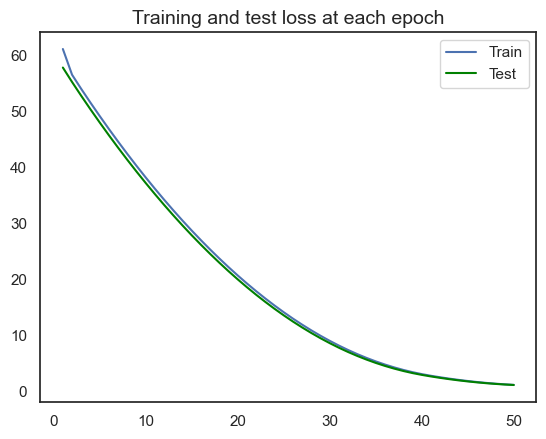

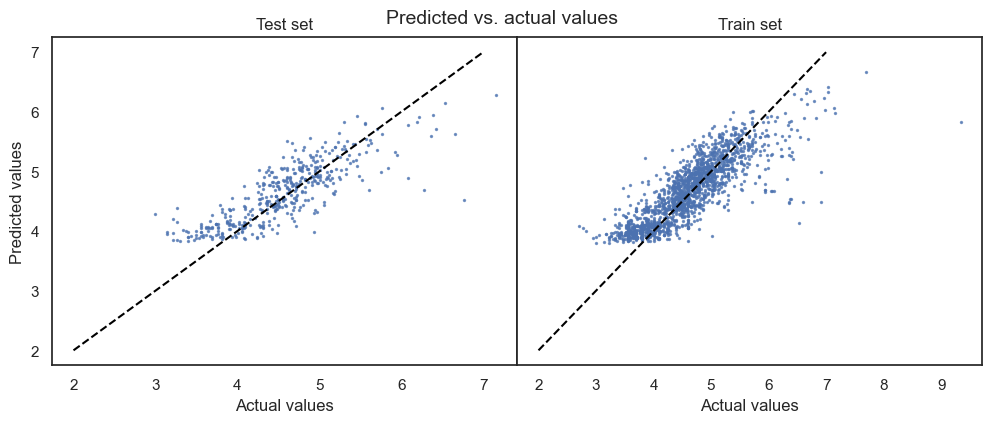

In [67]:
# Evaluating the model
nn_model_evaluation(model3_L1, model3_L1_history)

This Neural Network performs better than the previous model (**model2_3lnn**), as the MSE for the testing dataset is smaller. It also appears that the issues regarding overfitting have been amended as the MSE's for the testing and training data are similar. A key issue with this, is that it does not account for y values below 3.  

## Model 4: Neural network using the Adam optimizer

Model 4 is the same setup as Model 3, but the SGD optimizer has been replaced with the Adam optimizer.

In [68]:
# Setting the seed for reproducibility
seed = 1
random.seed(seed)
np.random.seed(seed)
tf.random.set_seed(seed)

# Building the model
model4_Adam = models.Sequential()
model4_Adam.add(layers.Dense(128, input_shape=(X_train.shape[1],), kernel_regularizer=regularizers.l1(0.005), activation='relu'))
model4_Adam.add(layers.Dense(256, kernel_regularizer=regularizers.l1(0.005), activation='relu'))
model4_Adam.add(layers.Dense(256, kernel_regularizer=regularizers.l1(0.005), activation='relu'))
model4_Adam.add(layers.Dense(512, kernel_regularizer=regularizers.l1(0.005), activation='relu'))
model4_Adam.add(layers.Dense(1, activation='linear'))

# Compiling the model
model4_Adam.compile(loss='mean_squared_error',
                    optimizer='adam', #adam optimizer
                    metrics=['mean_squared_error'])

# Model summary
print(model4_Adam.summary())


/Users/olivermorgan/anaconda3/lib/python3.11/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_9 (Dense)                 │ (None, 128)            │         6,784 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_10 (Dense)                │ (None, 256)            │        33,024 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_11 (Dense)                │ (None, 256)            │        65,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_12 (Dense)                │ (None, 512)            │       131,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_13 (Dense)                │ (None, 1)              │           513 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 237,697 (928.50 KB)

 Trainable params: 237,697 (928.50 KB)

 Non-trainable params: 0 (0.00 B)

None


In [69]:
# Training the model
model4_Adam_history = model4_Adam.fit(X_train,
                  y_train,
                  epochs=50,
                  batch_size=32,
                  validation_split = 0.2)

Epoch 1/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 4s 34ms/step - loss: 62.2835 - mean_squared_error: 7.3326 - val_loss: 40.3281 - val_mean_squared_error: 0.4368
Epoch 2/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - loss: 36.0834 - mean_squared_error: 0.3407 - val_loss: 25.9173 - val_mean_squared_error: 0.2887
Epoch 3/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 23.7343 - mean_squared_error: 0.2260 - val_loss: 18.5936 - val_mean_squared_error: 0.2716
Epoch 4/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - loss: 17.2531 - mean_squared_error: 0.1923 - val_loss: 14.0423 - val_mean_squared_error: 0.2570
Epoch 5/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - loss: 13.0995 - mean_squared_error: 0.1750 - val_loss: 10.8839 - val_mean_squared_error: 0.2415
Epoch 6/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 10.1860 - mean_squared_error: 0.1636 - val_loss: 8.5901 - val_mean_squared_error: 0.2309
Epoch 7/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - loss: 8.0561 - mean_squared_error: 0.1556 - val_loss: 

14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
55/55 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
Training MSE: 0.1536
Validation MSE: 0.1341

Training r2: 0.6844
Validation r2: 0.6829


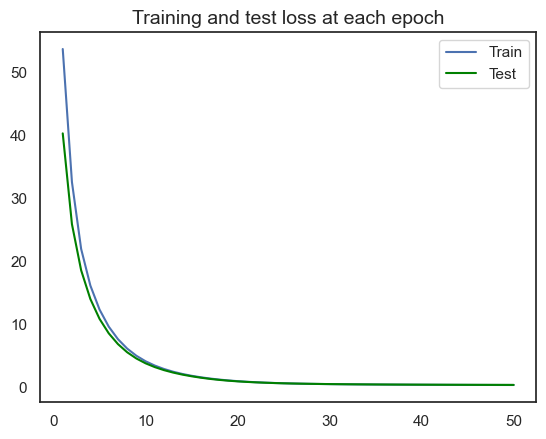

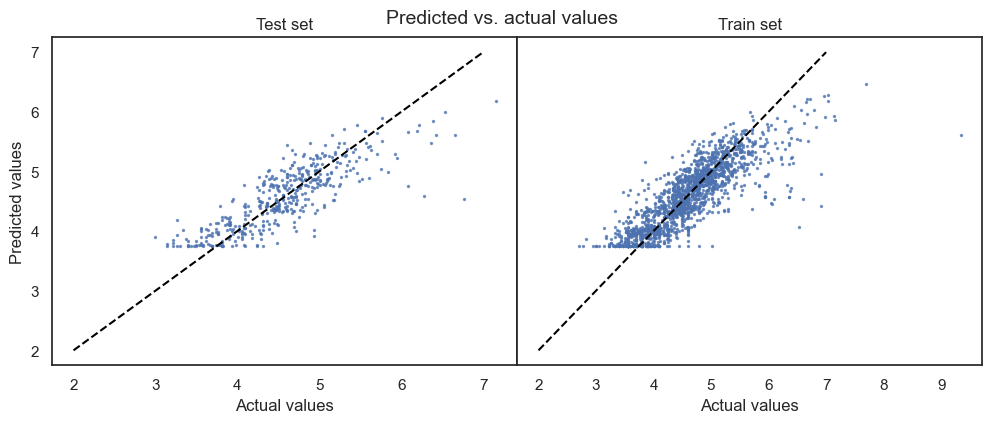

In [70]:
nn_model_evaluation(model4_Adam, model4_Adam_history)

The Adam optimizer performs slightly better than the SGD Optimizer, as the test MSE is slightly lower on the testing dataset. The MSE values between the models are faily similar and a different random split may lead to a certain optimizer performing better. The MSE is largely comparable to that given from the XGBoost, with this neural network not displaying overfiiting issues. This makes this model the best performing model.

As the Adam optimization is shown to perform slightly better, this optimizer is used in further models.

## Model 5 - Dropout regularization at 50%

This model is similar to model 4 (using the Adam optimizer), but uses a dropout regularization instead.  

In [71]:
# Setting the seed for reproducibility
seed = 1
random.seed(seed)
np.random.seed(seed)
tf.random.set_seed(seed)

# Building the model
model5_drop50 = models.Sequential()
model5_drop50.add(layers.Dropout(0.5, input_shape=(X_train.shape[1],)))  # Adding first dropout layer
model5_drop50.add(layers.Dense(128, activation='relu'))  # Adding first dense layer with ReLU activation
model5_drop50.add(layers.Dropout(0.5))  # Adding second dropout layer
model5_drop50.add(layers.Dense(256, activation='relu'))  # Adding second dense layer with ReLU activation
model5_drop50.add(layers.Dropout(0.5))  # Adding third dropout layer
model5_drop50.add(layers.Dense(512, activation='relu'))  # Adding third dense layer with ReLU activation
model5_drop50.add(layers.Dropout(0.5))  # Adding fourth dropout layer
model5_drop50.add(layers.Dense(1, activation='linear'))  # Adding output layer with linear activation

# Compiling the model
model5_drop50.compile(loss='mean_squared_error',
                      optimizer='adam',
                      metrics=['mean_squared_error'])

# Model summary
print(model5_drop50.summary())



/Users/olivermorgan/anaconda3/lib/python3.11/site-packages/keras/src/layers/regularization/dropout.py:42: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dropout (Dropout)               │ (None, 52)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_14 (Dense)                │ (None, 128)            │         6,784 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_15 (Dense)                │ (None, 256)            │        33,024 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_16 (Dense)                │ (None, 512)            │       131,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_17 (Dense)                │ (None, 1)              │           513 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 171,905 (671.50 KB)

 Trainable params: 171,905 (671.50 KB)

 Non-trainable params: 0 (0.00 B)

None


In [72]:
model5_drop50_history = model5_drop50.fit(X_train,
                  y_train,
                  epochs=50,
                  batch_size=32,
                  validation_split = 0.2)

Epoch 1/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 6s 30ms/step - loss: 12.6667 - mean_squared_error: 12.6667 - val_loss: 6.1263 - val_mean_squared_error: 6.1263
Epoch 2/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 2s 12ms/step - loss: 3.0743 - mean_squared_error: 3.0743 - val_loss: 5.1088 - val_mean_squared_error: 5.1088
Epoch 3/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - loss: 2.4081 - mean_squared_error: 2.4081 - val_loss: 6.2309 - val_mean_squared_error: 6.2309
Epoch 4/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 1.9787 - mean_squared_error: 1.9787 - val_loss: 4.4699 - val_mean_squared_error: 4.4699
Epoch 5/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 2.1262 - mean_squared_error: 2.1262 - val_loss: 4.2796 - val_mean_squared_error: 4.2796
Epoch 6/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 1.6157 - mean_squared_error: 1.6157 - val_loss: 4.6573 - val_mean_squared_error: 4.6573
Epoch 7/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 1.3344 - mean_squared_error: 1.3344 - val_loss: 3.9971 - val

14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
55/55 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
Training MSE: 0.3929
Validation MSE: 0.3317

Training r2: 0.1928
Validation r2: 0.2153


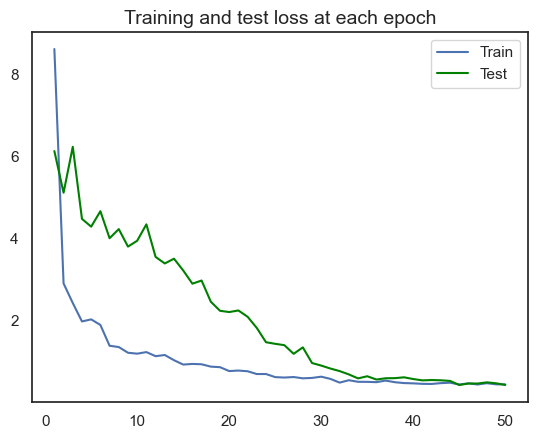

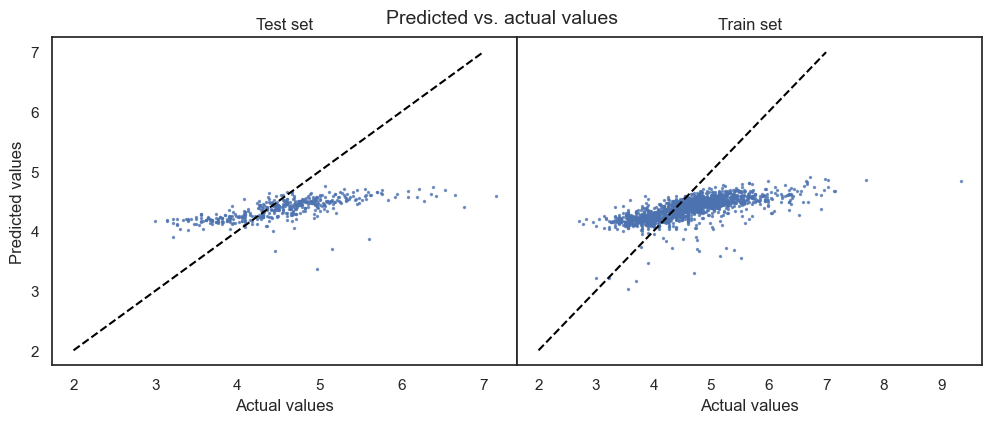

In [73]:
nn_model_evaluation(model5_drop50, model5_drop50_history)

Using dropout regularization has significantly reduced the model performance. This is the worst performing model so far!

## Model 6: Dropout regularization at 25%

To confirm that the dropout approach is not the correct method to use moving forward, a new model has been fitted with a smaller dropout. The batch size has also been doubled to improve model stability

In [74]:
# Setting the seed for reproducibility
seed = 1
random.seed(seed)
np.random.seed(seed)
tf.random.set_seed(seed)

# Building the model
model6_drop25 = models.Sequential()
model6_drop25.add(layers.Dropout(0.25, input_shape=(X_train.shape[1],)))  # Adding first dropout layer with 25% rate
model6_drop25.add(layers.Dense(128, activation='relu'))  # Adding first dense layer with ReLU activation
model6_drop25.add(layers.Dropout(0.25))  # Adding second dropout layer with 25% rate
model6_drop25.add(layers.Dense(256, activation='relu'))  # Adding second dense layer with ReLU activation
model6_drop25.add(layers.Dropout(0.25))  # Adding third dropout layer with 25% rate
model6_drop25.add(layers.Dense(512, activation='relu'))  # Adding third dense layer with ReLU activation
model6_drop25.add(layers.Dropout(0.25))  # Adding fourth dropout layer with 25% rate
model6_drop25.add(layers.Dense(1, activation='linear'))  # Adding output layer with linear activation

# Compiling the model
model6_drop25.compile(loss='mean_squared_error',
                      optimizer='adam',
                      metrics=['mean_squared_error'])

# Model summary
print(model6_drop25.summary())

/Users/olivermorgan/anaconda3/lib/python3.11/site-packages/keras/src/layers/regularization/dropout.py:42: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dropout_4 (Dropout)             │ (None, 52)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_18 (Dense)                │ (None, 128)            │         6,784 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_5 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_19 (Dense)                │ (None, 256)            │        33,024 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_6 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_20 (Dense)                │ (None, 512)            │       131,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_7 (Dropout)             │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_21 (Dense)                │ (None, 1)              │           513 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 171,905 (671.50 KB)

 Trainable params: 171,905 (671.50 KB)

 Non-trainable params: 0 (0.00 B)

None


In [75]:
model6_drop25_history = model6_drop25.fit(X_train,
                  y_train,
                  epochs=50,
                  batch_size=64,
                  validation_split = 0.2)

Epoch 1/50
22/22 ━━━━━━━━━━━━━━━━━━━━ 2s 19ms/step - loss: 10.4905 - mean_squared_error: 10.4905 - val_loss: 2.2746 - val_mean_squared_error: 2.2746
Epoch 2/50
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 1.3907 - mean_squared_error: 1.3907 - val_loss: 1.3690 - val_mean_squared_error: 1.3690
Epoch 3/50
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.9772 - mean_squared_error: 0.9772 - val_loss: 1.2830 - val_mean_squared_error: 1.2830
Epoch 4/50
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.8764 - mean_squared_error: 0.8764 - val_loss: 1.1832 - val_mean_squared_error: 1.1832
Epoch 5/50
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.8166 - mean_squared_error: 0.8166 - val_loss: 1.2723 - val_mean_squared_error: 1.2723
Epoch 6/50
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.6630 - mean_squared_error: 0.6630 - val_loss: 1.5429 - val_mean_squared_error: 1.5429
Epoch 7/50
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.6403 - mean_squared_error: 0.6403 - val_loss: 1.1370 - v

14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
55/55 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step
Training MSE: 0.4249
Validation MSE: 0.3915

Training r2: 0.1271
Validation r2: 0.0739


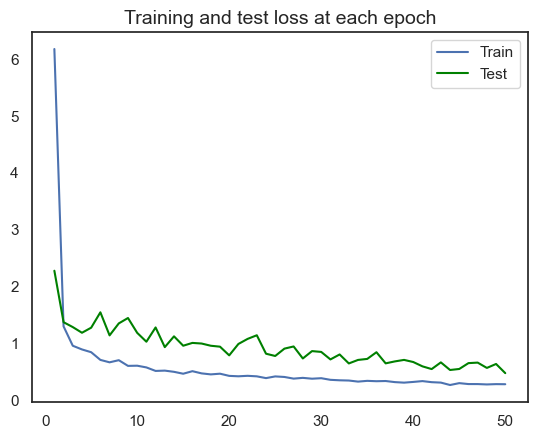

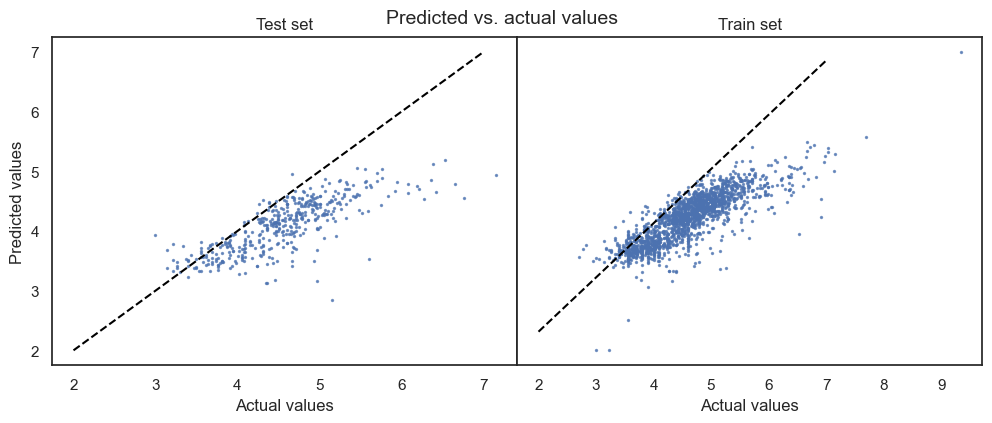

In [76]:
nn_model_evaluation(model6_drop25, model6_drop25_history)

Even with a doubling in batch size and a reduced dropout rate, the MSE's remain considerably high. The MSE has increased further which highlights the fact that dropout regularization is not useful. The L1 regularization approach with the Adam optimizer (model 4) remains the best model. 

## Model 7: Removing the review rating features

Adding layers to neural networks requires greater computational energy. Before considering extra layers, it is worth checking whether the removal of certain features leads to better model accuracy. 

From the correlation matrix generated earlier in this research, there was high multicollinearity between the seperate review features. These were kept in to see whether they were important for predicting AirBnB listing prices. 

When feature importance was calculated in the XGBoost model, a large proportion of these features had little importance, however the **review_scores_checkin_4/5** and **review_scores_accuracy_5/5** made it into the top 10 most important features. 

With this in mind, all of the review columns, apart from the overall review ratings, **review_scores_checkin_4/5** and **review_scores_accuracy_5/5**, will be removed to reduce the effect of this multicollinearity.

The same structure as model 4 is used be used.

In [77]:
# Setting the seed for reproducibility
seed = 1
random.seed(seed)
np.random.seed(seed)
tf.random.set_seed(seed)

# Retrieving the list of columns that start with "review_scores"
excess_reviews = list(X_train.columns[X_train.columns.str.startswith("review_scores")])

# Defining the columns to keep
reviews_keep = [
    "review_scores_rating", 
    "review_scores_checkin_4/5", 
    "review_scores_accuracy_5/5"
]

# Filtering out the columns that are not in the keep list
reviews_drop = [col for col in excess_reviews if col not in reviews_keep]

# Dropping the unnecessary columns from both training and test sets
X_train_short = X_train.drop(reviews_drop, axis=1)
X_test_short = X_test.drop(reviews_drop, axis=1)

In [78]:
# Building the model
model7_reviews = models.Sequential()
model7_reviews.add(layers.Dense(128, input_shape=(X_train_short.shape[1],), kernel_regularizer=regularizers.l1(0.005), activation='relu'))
model7_reviews.add(layers.Dense(256, kernel_regularizer=regularizers.l1(0.005), activation='relu'))
model7_reviews.add(layers.Dense(256, kernel_regularizer=regularizers.l1(0.005), activation='relu'))
model7_reviews.add(layers.Dense(512, kernel_regularizer=regularizers.l1(0.005), activation='relu'))
model7_reviews.add(layers.Dense(1, activation='linear'))

# Compiling the model
model7_reviews.compile(loss='mean_squared_error',
                       optimizer='adam',
                       metrics=['mean_squared_error'])

# Model summary
print(model7_reviews.summary())


/Users/olivermorgan/anaconda3/lib/python3.11/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_5"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_22 (Dense)                │ (None, 128)            │         4,352 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_23 (Dense)                │ (None, 256)            │        33,024 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_24 (Dense)                │ (None, 256)            │        65,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_25 (Dense)                │ (None, 512)            │       131,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_26 (Dense)                │ (None, 1)              │           513 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 235,265 (919.00 KB)

 Trainable params: 235,265 (919.00 KB)

 Non-trainable params: 0 (0.00 B)

None


In [79]:
model7_reviews_history = model7_reviews.fit(X_train_short,
                  y_train,
                  epochs=50,
                  batch_size=32,
                  validation_split=0.2)

Epoch 1/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 3s 24ms/step - loss: 60.8926 - mean_squared_error: 7.1412 - val_loss: 38.5326 - val_mean_squared_error: 0.5044
Epoch 2/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 34.0919 - mean_squared_error: 0.3532 - val_loss: 23.6646 - val_mean_squared_error: 0.2869
Epoch 3/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - loss: 21.4814 - mean_squared_error: 0.2195 - val_loss: 16.4002 - val_mean_squared_error: 0.2597
Epoch 4/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 15.1141 - mean_squared_error: 0.1898 - val_loss: 12.0341 - val_mean_squared_error: 0.2455
Epoch 5/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - loss: 11.1571 - mean_squared_error: 0.1728 - val_loss: 9.0856 - val_mean_squared_error: 0.2247
Epoch 6/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 8.4615 - mean_squared_error: 0.1611 - val_loss: 7.0094 - val_mean_squared_error: 0.2102
Epoch 7/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - loss: 6.5491 - mean_squared_error: 0.1522 - val_loss: 5.

14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
55/55 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
Training MSE: 0.1499
Validation MSE: 0.1322

Training r2: 0.6921
Validation r2: 0.6872


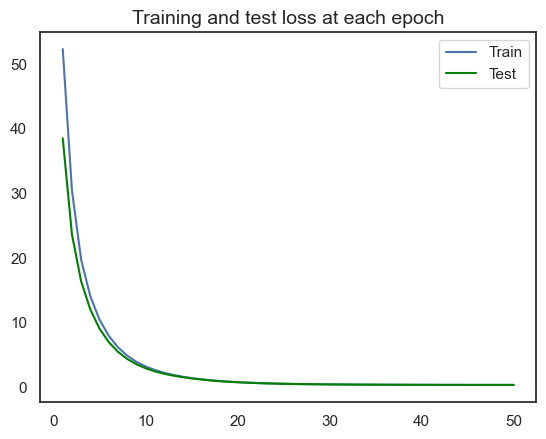

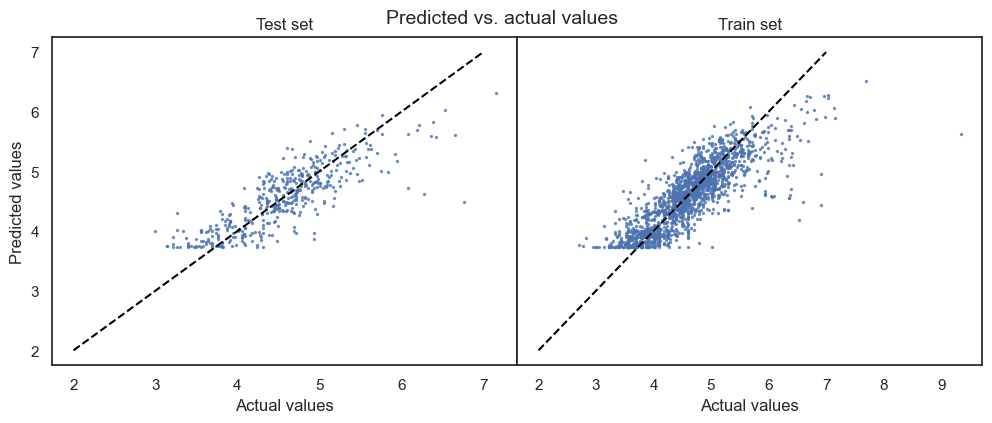

In [80]:
nn_model_evaluation(model7_reviews, 
                    model7_reviews_history, 
                    X_train=X_train_short, #using the data with reviews removed 
                    X_test=X_test_short) #using the data with reviews removed

The MSE for both the training and testing data have notably decreased from the values given from model 4 (the previous best model). This shows that dropping the excess variables has improved the model performance. The MSE values between the training and testing data are similar, which suggests that overfitting is not a problem, which is supported by the scatter plots provided. This is the best neural network model, as it is efficient and requires less computational effort.

## Model 8: Adding an extra layer and using a min-max scaler

Finally, a min-max scaling (0-1) is applied and an additional layer is given for model 8 to see if this is able to improve its performance further

In [81]:
# Dropping review columns from the original dataframe (after log transformation)
AirBnB_minmax = transformed_AirBnB.drop(reviews_drop, axis=1)

# Separating X and y
X_minmax = AirBnB_minmax.drop('price', axis=1)
y_minmax = AirBnB_minmax.price

# Scaling
scaler = MinMaxScaler(feature_range=(0, 1))
X_minmax = pd.DataFrame(scaler.fit_transform(X_minmax), columns=list(X_minmax.columns))

# Splitting into train and test sets
X_train_minmax, X_test_minmax, y_train_minmax, y_test_minmax = train_test_split(X_minmax, y_minmax, test_size=0.2, random_state=1)

In [82]:
# Setting the seed for reproducibility
seed = 1
random.seed(seed)
np.random.seed(seed)
tf.random.set_seed(seed)

# Building the model
model8_minmax = models.Sequential()
model8_minmax.add(layers.Dense(128, input_shape=(X_train_minmax.shape[1],), kernel_regularizer=regularizers.l1(0.005), activation='relu'))
model8_minmax.add(layers.Dense(256, kernel_regularizer=regularizers.l1(0.005), activation='relu'))
model8_minmax.add(layers.Dense(256, kernel_regularizer=regularizers.l1(0.005), activation='relu'))
model8_minmax.add(layers.Dense(512, kernel_regularizer=regularizers.l1(0.005), activation='relu'))
model8_minmax.add(layers.Dense(1024, kernel_regularizer=regularizers.l1(0.005), activation='relu')) #new layer added
model8_minmax.add(layers.Dense(1, activation='linear'))

# Compiling the model
model8_minmax.compile(loss='mean_squared_error',
                      optimizer='adam',
                      metrics=['mean_squared_error'])

# Model summary
print(model8_minmax.summary())

/Users/olivermorgan/anaconda3/lib/python3.11/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_6"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_27 (Dense)                │ (None, 128)            │         4,352 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_28 (Dense)                │ (None, 256)            │        33,024 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_29 (Dense)                │ (None, 256)            │        65,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_30 (Dense)                │ (None, 512)            │       131,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_31 (Dense)                │ (None, 1024)           │       525,312 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_32 (Dense)                │ (None, 1)              │         1,025 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 761,089 (2.90 MB)

 Trainable params: 761,089 (2.90 MB)

 Non-trainable params: 0 (0.00 B)

None


In [83]:
model8_minmax_history = model8_minmax.fit(X_train_minmax,
                  y_train_minmax,
                  epochs=50,
                  batch_size=32,
                  validation_split = 0.2)

Epoch 1/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 4s 30ms/step - loss: 119.1637 - mean_squared_error: 5.8399 - val_loss: 47.8183 - val_mean_squared_error: 0.3892
Epoch 2/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 1s 26ms/step - loss: 37.2729 - mean_squared_error: 0.3087 - val_loss: 18.8114 - val_mean_squared_error: 0.3060
Epoch 3/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 1s 27ms/step - loss: 16.3040 - mean_squared_error: 0.2588 - val_loss: 11.1753 - val_mean_squared_error: 0.2404
Epoch 4/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 1s 30ms/step - loss: 10.2072 - mean_squared_error: 0.2450 - val_loss: 7.9099 - val_mean_squared_error: 0.2530
Epoch 5/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 1s 25ms/step - loss: 7.3661 - mean_squared_error: 0.2554 - val_loss: 6.0166 - val_mean_squared_error: 0.2323
Epoch 6/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 1s 25ms/step - loss: 5.6930 - mean_squared_error: 0.2432 - val_loss: 4.8441 - val_mean_squared_error: 0.2333
Epoch 7/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 1s 25ms/step - loss: 4.6303 - mean_squared_error: 0.2465 - val_loss: 4.0

14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 24ms/step
55/55 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
Training MSE: 0.1788
Validation MSE: 0.1505

Training r2: 0.6327
Validation r2: 0.644


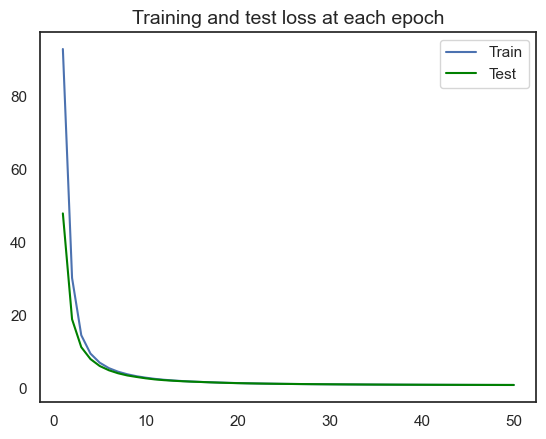

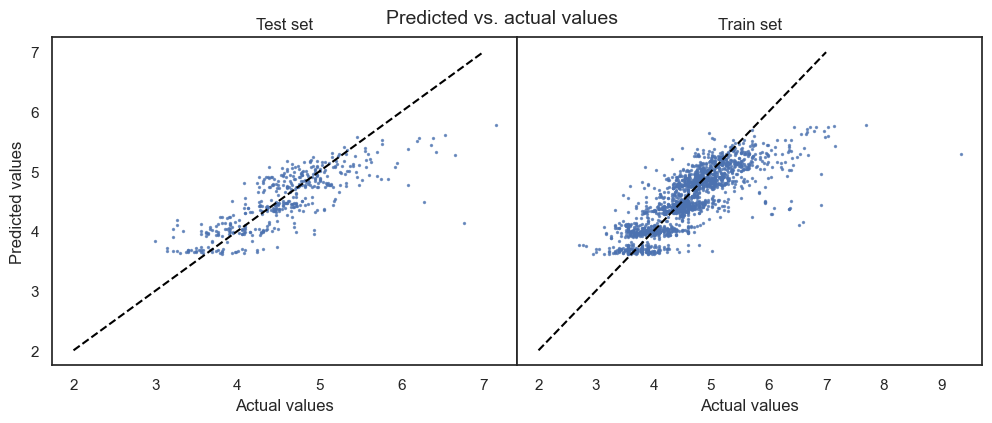

In [84]:
nn_model_evaluation(model8_minmax, model8_minmax_history, X_train=X_train_minmax, X_test=X_test_minmax, y_train=y_train_minmax, y_test=y_test_minmax)

The MSE's do not reduce any further and therefore the addition of the min-max scaler and the extra layer has not contributed towards better model predictions

## Conclusions

Overall, the best performing and most reliable is model 7, which uses L1 regularization, the Adam optimizer and removed the excess review columns. This is because it has the lowest MSE out of all of the other neural networks considered. Other networks considered explored dropout regularization, different optimizers and min-max scaling but this did not seem to improve model predictions.

Arguably, the XGBoost model had the lowest MSE scores, for the test data, however the the presence of overfitting is likely, and therefore the model may be unreliable by missing underlying trends due to listening to heavily to noise